In [56]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union

In [57]:
COLOR_MAP = {
    'embedding': 'blue',
    'attention': 'purple',
    'ffn': 'brown',
    'dropout': 'grey',
}

def get_colors(index: List[str], color_map: dict = COLOR_MAP):
    return [
        color_map['embedding'] if 'embedding' in idx.lower() 
        else color_map['attention'] if 'attention' in idx.lower() or 'attn' in idx.lower()
        else color_map['layernorm'] if 'ln' in idx.lower() or 'layernorm' in idx.lower()
        else color_map['ffn'] if (
            'mlp' in idx.lower() or 
            'linear' in idx.lower() or 
            'pooler' in idx.lower() or 
            'intermediate' in idx.lower() or
            'output' in idx.lower()
        )
        else color_map['dropout'] if 'dropout' in idx.lower()
        else 'red'  # default color 
        for idx in index]

In [2]:
# bert_latency_res = pd.read_csv('profile_res/latency_bert-base-uncased_res.csv')
gpt2_latency_res = pd.read_csv('profile_res/latency_gpt2_res.csv')
# bart_latency_res = pd.read_csv('profile_res/latency_bart-base_res.csv')

# bert_memory_res = pd.read_csv('profile_res/memory_bert-base-uncased_res.csv')
gpt2_memory_res = pd.read_csv('profile_res/memory_gpt2_res.csv')
# bart_memory_res = pd.read_csv('profile_res/memory_bart-base_res.csv')

In [62]:
# Plot the average latency distribution of each layer
def plot_layer_profiling(
    profile_res: pd.DataFrame, 
    model_name: str, 
    save_file: str = None,
    color_map: dict = COLOR_MAP,
    metric: str = 'inference latency',
    unit: str = 'seconds',
    figsize: Tuple[int, int] = (20, 6),
):
    # Assuming you have the DataFrame loaded as df (do not include the batch_size, input_length columns)
    if 'batch_size' in profile_res.columns and 'input_length' in profile_res.columns:
        res = profile_res.drop(columns=['batch_size', 'input_length'])
    else:
        res = profile_res
    averages = res.mean()
    
    # Determine the color of each bar based on its label
    colors = get_colors(averages.index)
    
    # Create custom patches for legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[key], label=key) for key in color_map]

    # Plotting
    plt.figure(figsize=figsize)
    averages.plot(kind='bar', color=colors, width=0.5)
    
    # Also plot line graph
    plt.plot(averages, color='black', linestyle='-', linewidth=2)
    
    plt.ylabel(f'Average {metric} ({unit})', fontdict={'fontsize': 12})
    plt.xlabel('Layer', fontdict={'fontsize': 12})
    plt.title(f'Average {metric} per Layer for {model_name}')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    
    # Add legend for the 6 layers
    plt.legend(handles=legend_elements, title="Layer type")
    plt.tight_layout()
    
    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

In [61]:
def plot_layer_profiling_dist(
    profile_res: pd.DataFrame, 
    model_name: str, 
    save_file: str = None,
    color_map: dict = COLOR_MAP,
    metric: str = 'inference latency',
    unit: str = 'seconds',
    figsize: Tuple[int, int] = (20, 6),
):
    
    # Assuming you have the DataFrame loaded as df (do not include the batch_size, input_length columns)
    # If res has columns batch_size and input_length, drop them
    if 'batch_size' in profile_res.columns and 'input_length' in profile_res.columns:
        res = profile_res.drop(columns=['batch_size', 'input_length'])
    else:
        res = profile_res
    
    # Determine the color of each column based on its label
    column_colors = get_colors(res.columns)

    # Create custom patches for legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[key], label=key) for key in color_map]
    
    # Plotting
    plt.figure(figsize=figsize)
    
    # Boxplot
    boxprops = dict(linestyle='-', linewidth=1)
    medianprops = dict(linestyle='-', linewidth=2, color='black')
    # res.boxplot(column=res.columns, vert=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops)
    bp = res.boxplot(
        vert=True, 
        patch_artist=True, 
        boxprops=boxprops, 
        medianprops=medianprops, 
        showfliers=False, 
        return_type='dict',
    )
    
    # # Coloring the boxes based on the determined colors
    # for patch, color in zip(plt.gca().artists, column_colors):
    #     patch.set_facecolor(color)
    # Coloring the boxes based on the determined colors
    for patch, color in zip(bp['boxes'], column_colors):
        patch.set_facecolor(color)
    
    plt.xlabel('Layer', fontdict={'fontsize': 12})
    plt.ylabel(f'{metric} ({unit})', fontdict={'fontsize': 12})
    plt.title(f'Distribution of {metric} per Layer for {model_name}')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    
    # Add legend for the layer types with a title
    plt.legend(handles=legend_elements, title="Layer type")
    
    plt.tight_layout()
    
    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()


In [48]:
def plot_layer_profiling_split(
    profile_res: pd.DataFrame, 
    model_name: str, 
    save_file: str = None,
    color_map: dict = None,
    metric: str = 'inference latency',
    unit: str = 'seconds',
):
    if color_map is None:
        color_map = {
            'embedding_layer': 'blue',
            'ln_1': 'orange',
            'attn': 'purple',
            'ln_2': 'green',
            'mlp': 'brown',
            'FC_layer': 'red',
        }
    
    # Create custom patches for legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[key], label=key) for key in color_map]
    
    # Split data based on input_length
    # Quantiles for splitting
    # q1 = profile_res['input_length'].quantile(0.1)
    # q2 = profile_res['input_length'].quantile(0.5)
    # small_data = profile_res[profile_res['input_length'] <= q1].drop(columns=['batch_size', 'input_length'])
    # normal_data = profile_res[(profile_res['input_length'] > q1) & (profile_res['input_length'] <= q2)].drop(columns=['batch_size', 'input_length'])
    # large_data = profile_res[profile_res['input_length'] > q2].drop(columns=['batch_size', 'input_length'])
    small_data = profile_res[profile_res['input_length'] <= 128].drop(columns=['batch_size', 'input_length'], ignore_errors=True)
    normal_data = profile_res[(profile_res['input_length'] > 128) & (profile_res['input_length'] <= 512)].drop(columns=['batch_size', 'input_length'], ignore_errors=True)
    large_data = profile_res[profile_res['input_length'] > 512].drop(columns=['batch_size', 'input_length'], ignore_errors=True)
    
    plt.figure(figsize=(15, 15))
    data_splits = [('Small', small_data), ('Normal', normal_data), ('Large', large_data)]
    for i, (split_name, data) in enumerate(data_splits, 1):
        plt.subplot(3, 1, i)
        
        # Determine the color of each column based on its label
        column_colors = [color_map['embedding_layer'] if 'embedding' in idx 
                        else color_map['ln_1'] if 'ln_1' in idx
                        else color_map['attn'] if 'attn' in idx
                        else color_map['ln_2'] if 'ln_2' in idx
                        else color_map['mlp'] if 'mlp' in idx
                        else color_map['FC_layer'] if 'FC' in idx 
                        else 'grey'  # default color 
                        for idx in data.columns]

        # Box plot of the data without outliers
        boxprops = dict(linestyle='-', linewidth=1)
        medianprops = dict(linestyle='-', linewidth=2, color='black')
        bp = data.boxplot(vert=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, showfliers=False, return_type='dict')
        
        # Coloring the boxes based on the determined colors
        for patch, color in zip(bp['boxes'], column_colors):
            patch.set_facecolor(color)

        plt.ylabel(f'{metric} ({unit})', fontdict={'fontsize': 12})
        plt.xlabel('Layer', fontdict={'fontsize': 12})
        plt.title(f'Distribution of {metric} for {split_name} Input Length in {model_name}')
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        
        # Custom legend only for the first subplot
        if i == 1:
            plt.legend(handles=legend_elements, title="Layer type")
    
    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()


In [49]:
def plot_pie_chart(
    profile_res: pd.DataFrame, 
    model_name: str, 
    save_file: str = None,
    color_map: dict = None,
    metric: str = 'inference latency',
):
    if color_map is None:
        color_map = {
            'embedding_layer': 'blue',
            'ln_1': 'orange',
            'attn': 'purple',
            'ln_2': 'green',
            'mlp': 'brown',
            'FC_layer': 'red',
        }
    
    # Extract only the layer columns (excluding batch_size and input_length)
    res = profile_res.drop(columns=['batch_size', 'input_length'], ignore_errors=True)
    
    # Dictionary to store the summed latency for each layer type
    layer_sum = {
        'embedding_layer': 0,
        'ln_1': 0,
        'attn': 0,
        'ln_2': 0,
        'mlp': 0,
        'FC_layer': 0
    }
    
    # Sum up latencies for each layer type
    for column in res.columns:
        if 'embedding' in column:
            layer_sum['embedding_layer'] += res[column].sum()
        elif 'ln_1' in column:
            layer_sum['ln_1'] += res[column].sum()
        elif 'attn' in column:
            layer_sum['attn'] += res[column].sum()
        elif 'ln_2' in column:
            layer_sum['ln_2'] += res[column].sum()
        elif 'mlp' in column:
            layer_sum['mlp'] += res[column].sum()
        elif 'FC' in column:
            layer_sum['FC_layer'] += res[column].sum()
    
    # Pie chart
    plt.figure(figsize=(10, 8))
    # plt.pie(layer_sum.values(), labels=layer_sum.keys(), autopct='%1.1f%%', startangle=140, colors=[color_map[key] for key in layer_sum.keys()])
    patches, texts, autotexts = plt.pie(layer_sum.values(), autopct='%1.1f%%', startangle=140, colors=[color_map[key] for key in layer_sum.keys()])
    plt.title(f'Layer-wise Latency Distribution for {model_name}')
    plt.title(f'Percentage of {metric} for different types of layers in {model_name}')
    
    # Add legend
    # legend_labels = [f"{key.replace('_', ' ').title()}" for key in layer_sum.keys()]
    legend_labels = [f"{key}" for key in layer_sum.keys()]
    plt.legend(patches, legend_labels, loc="best", title="Layer Type")
    
    # Improve appearance
    for t in texts:
        t.set(size=10)
    for at in autotexts:
        at.set(size=10, weight="bold")
    
    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

In [50]:
def plot_combined_charts(
    profile_res: pd.DataFrame, 
    model_name: str, 
    save_file: str = None,
    color_map: dict = None,
    metric: str = 'inference latency',
    unit: str = 'seconds',
):
    if color_map is None:
        color_map = {
            'embedding_layer': 'blue',
            'ln_1': 'orange',
            'attn': 'purple',
            'ln_2': 'green',
            'mlp': 'brown',
            'FC_layer': 'red',
        }
    
    # Split data into Small, Normal, and Large subsets
    small_data = profile_res[profile_res['input_length'] <= 128].drop(
        columns=['batch_size', 'input_length'], 
        ignore_errors=True,
    )
    normal_data = profile_res[(profile_res['input_length'] > 128) & (profile_res['input_length'] <= 512)].drop(
        columns=['batch_size', 'input_length'],
        ignore_errors=True,
    )
    large_data = profile_res[profile_res['input_length'] > 512].drop(
        columns=['batch_size', 'input_length'], 
        ignore_errors=True,
    )
    
    data_subsets = [small_data, normal_data, large_data]
    subset_names = ['Small', 'Normal', 'Large']
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 18), width_ratios=[3, 1])
    
    for i, (data, subset_name) in enumerate(zip(data_subsets, subset_names)):
        # First column: box plots
        column_colors = [color_map['embedding_layer'] if 'embedding' in idx 
                else color_map['ln_1'] if 'ln_1' in idx
                else color_map['attn'] if 'attn' in idx
                else color_map['ln_2'] if 'ln_2' in idx
                else color_map['mlp'] if 'mlp' in idx
                else color_map['FC_layer'] if 'FC' in idx 
                else 'grey' for idx in data.columns]
        
        # Boxplot
        boxprops = dict(linestyle='-', linewidth=1)
        medianprops = dict(linestyle='-', linewidth=2, color='black')
        bp = data.boxplot(ax=axes[i, 0], vert=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, showfliers=False, return_type='dict')
        # Coloring the boxes based on the determined colors
        for patch, color in zip(bp['boxes'], column_colors):
            patch.set_facecolor(color)
            
        axes[i, 0].set_title(f'{subset_name} Input Length: Distribution of Latency for {model_name}')
        axes[i, 0].set_xlabel('Layer', fontdict={'fontsize': 12})
        axes[i, 0].set_ylabel(f'{metric} ({unit})', fontdict={'fontsize': 12})
        axes[i, 0].set_xticklabels(data.columns, rotation=45, ha='right')
        axes[i, 0].grid(axis='y')
        
        # Second column: pie charts
        # Sum up latencies for each layer type
        layer_sum = {
            'embedding_layer': 0,
            'ln_1': 0,
            'attn': 0,
            'ln_2': 0,
            'mlp': 0,
            'FC_layer': 0
        }
        for column in data.columns:
            if 'embedding' in column:
                layer_sum['embedding_layer'] += data[column].sum()
            elif 'ln_1' in column:
                layer_sum['ln_1'] += data[column].sum()
            elif 'attn' in column:
                layer_sum['attn'] += data[column].sum()
            elif 'ln_2' in column:
                layer_sum['ln_2'] += data[column].sum()
            elif 'mlp' in column:
                layer_sum['mlp'] += data[column].sum()
            elif 'FC' in column:
                layer_sum['FC_layer'] += data[column].sum()
        
        # Pie chart
        patches, texts, autotexts = axes[i, 1].pie(layer_sum.values(), autopct='%1.1f%%', startangle=140, colors=[color_map[key] for key in layer_sum.keys()])
        
        # Improve appearance of pie chart
        for t in texts:
            t.set(size=10)
        for at in autotexts:
            at.set(size=10, weight="bold")
    
    # Add legend for pie chart
    legend_labels = [f"{key}" for key in layer_sum.keys()]
    fig.legend(patches, legend_labels, loc='upper right', title="Layer Type")
    
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

In [25]:
if not os.path.exists('figures'):
    os.makedirs('figures')

plot_layer_profiling(
    bert_latency_res, 
    'BERT-base', 
    save_file='figures/bert_layer_latency.pdf',
    metric='inference latency',
    unit='seconds',
)

NameError: name 'bert_latency_res' is not defined

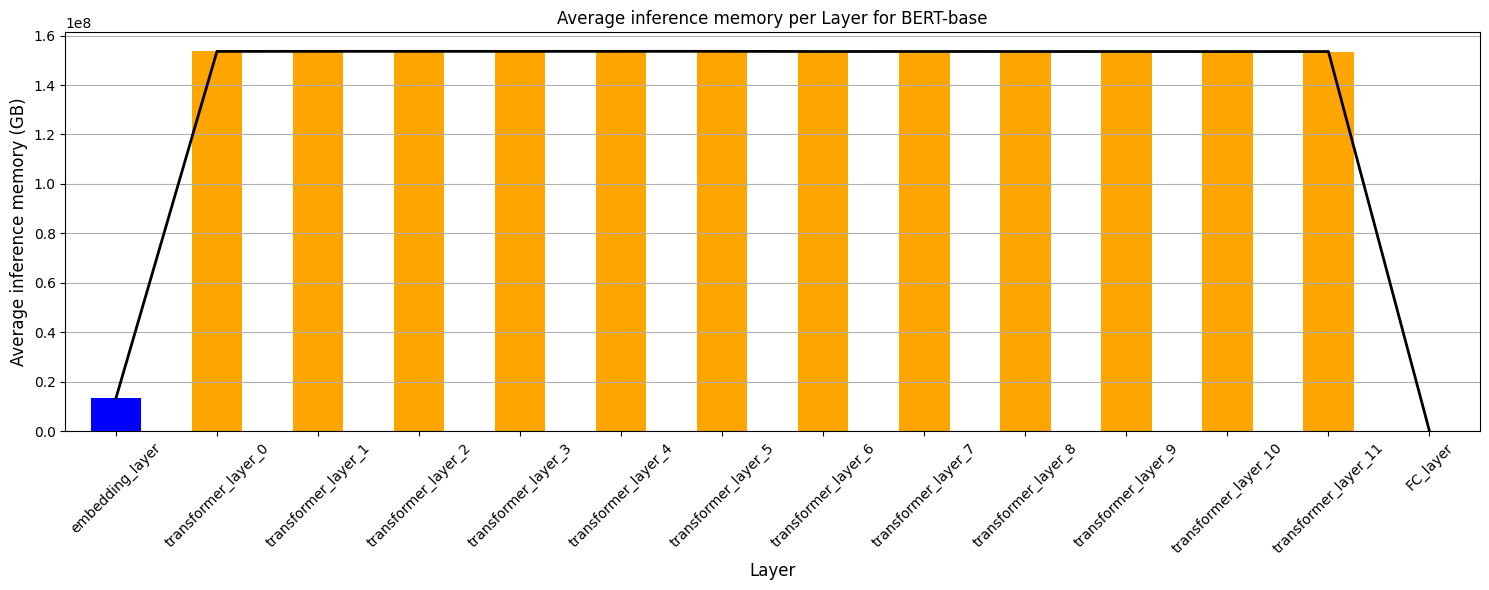

In [47]:
plot_layer_profiling(
    bert_memory_res, 
    'BERT-base', 
    save_file='figures/bert_layer_memory.pdf',
    metric='inference memory',
    unit='GB',
)

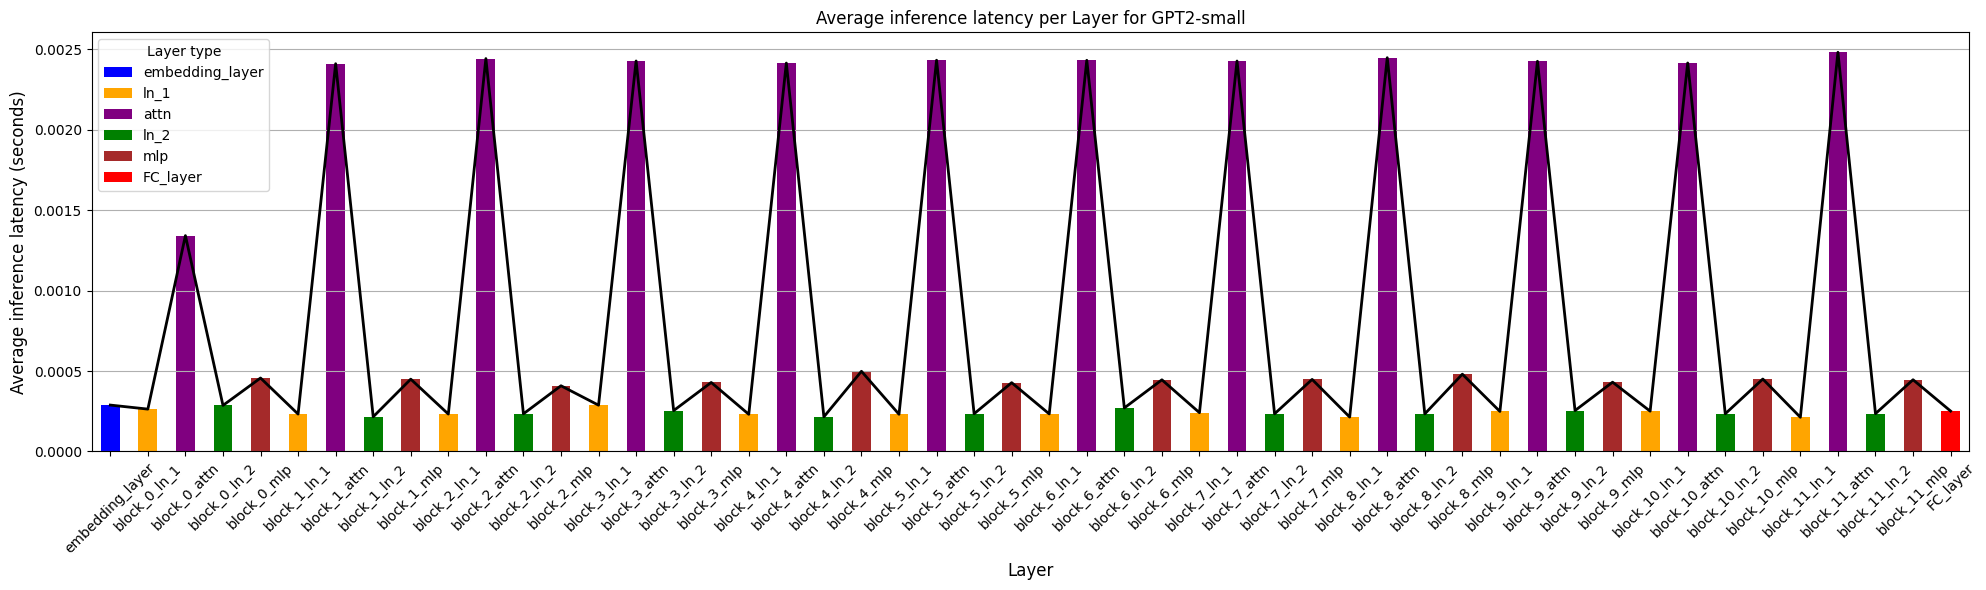

In [43]:
plot_layer_profiling(
    gpt2_latency_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_latency.pdf',
    metric='inference latency',
    unit='seconds',
)

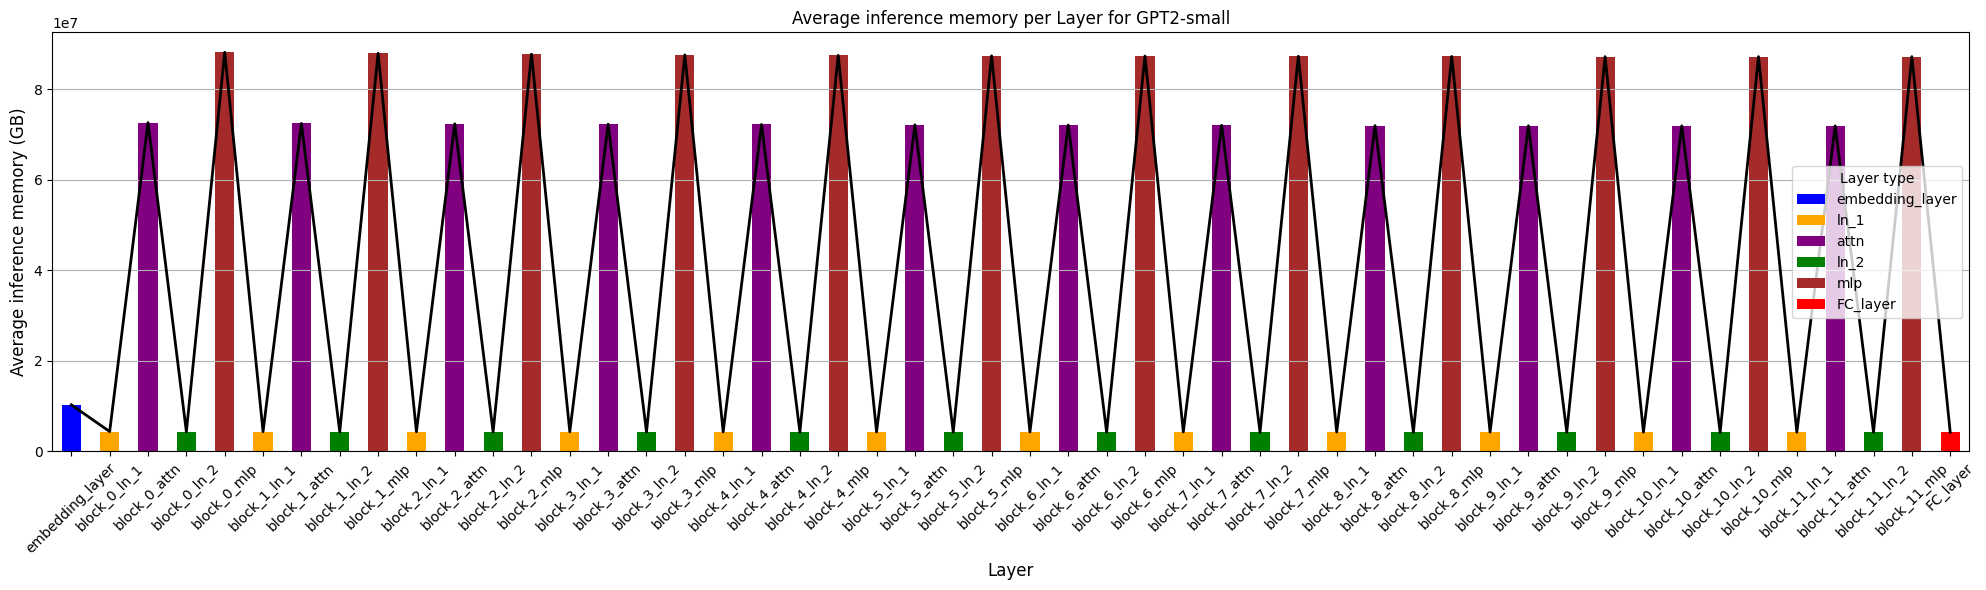

In [44]:
plot_layer_profiling(
    gpt2_memory_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_memory.pdf',
    metric='inference memory',
    unit='GB',
)

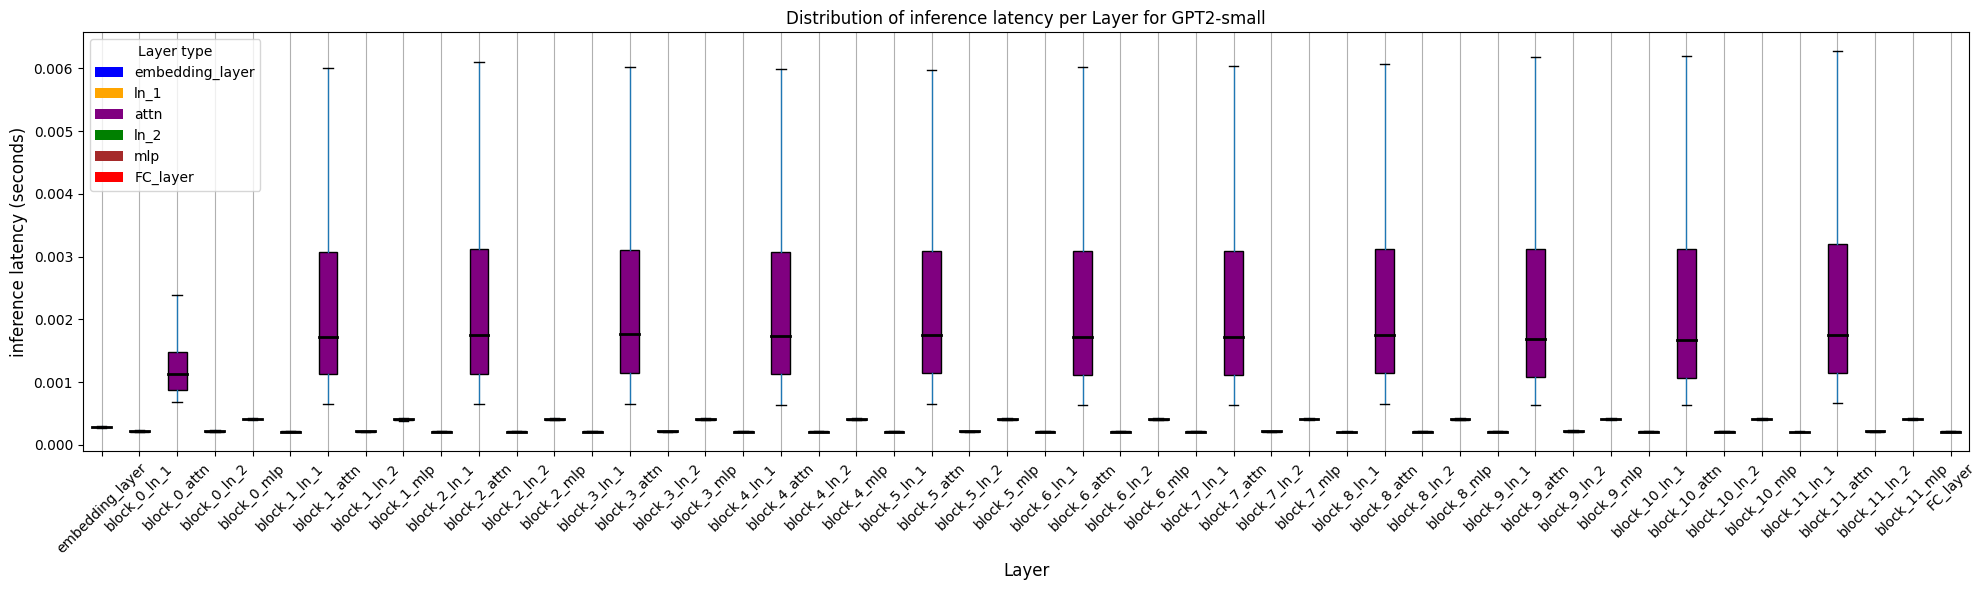

In [45]:
plot_layer_profiling_dist(
    gpt2_latency_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_latency_dist.pdf',
    metric='inference latency',
    unit='seconds',
)

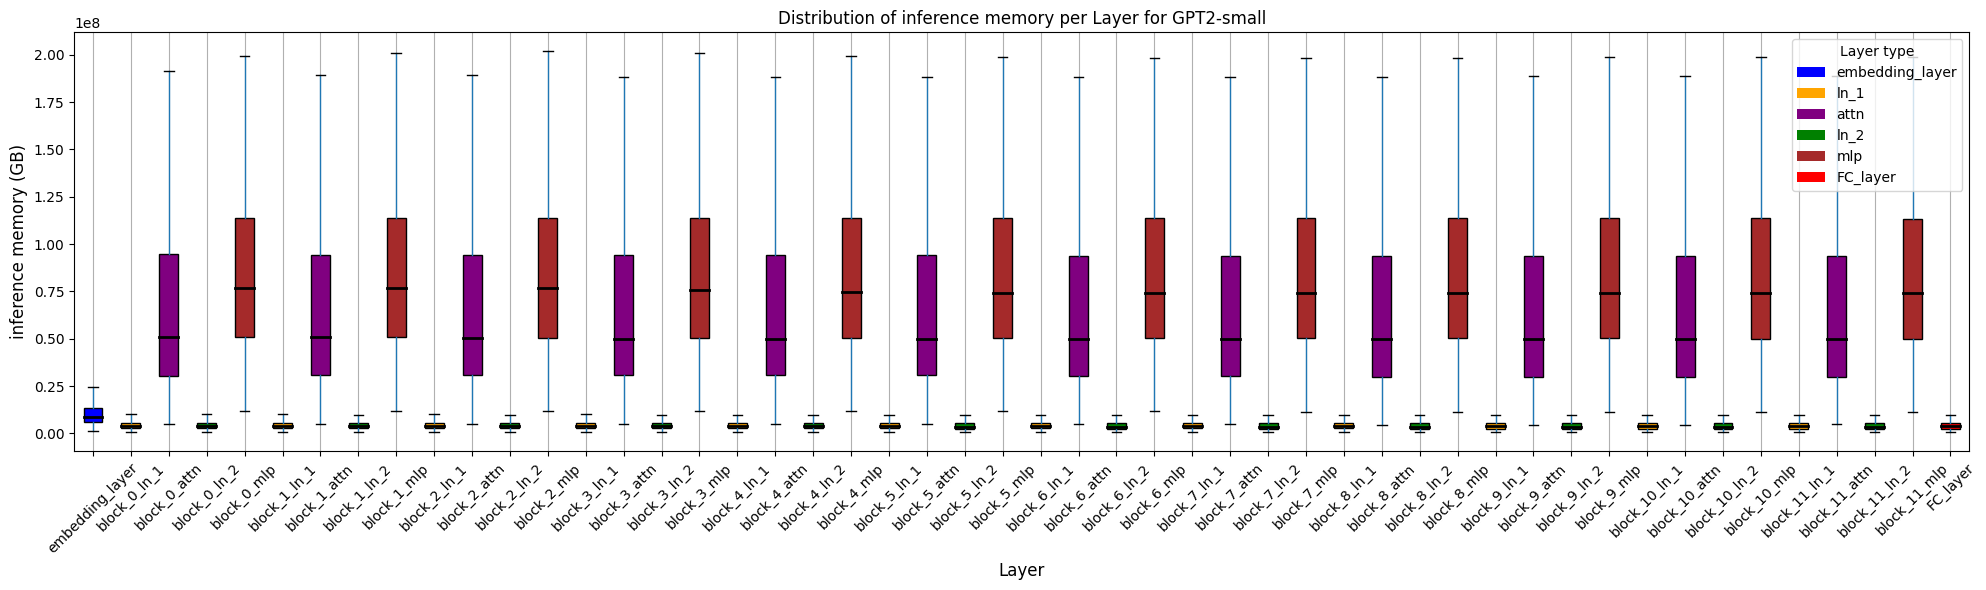

In [46]:
plot_layer_profiling_dist(
    gpt2_memory_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_memory_dist.pdf',
    metric='inference memory',
    unit='GB',
)

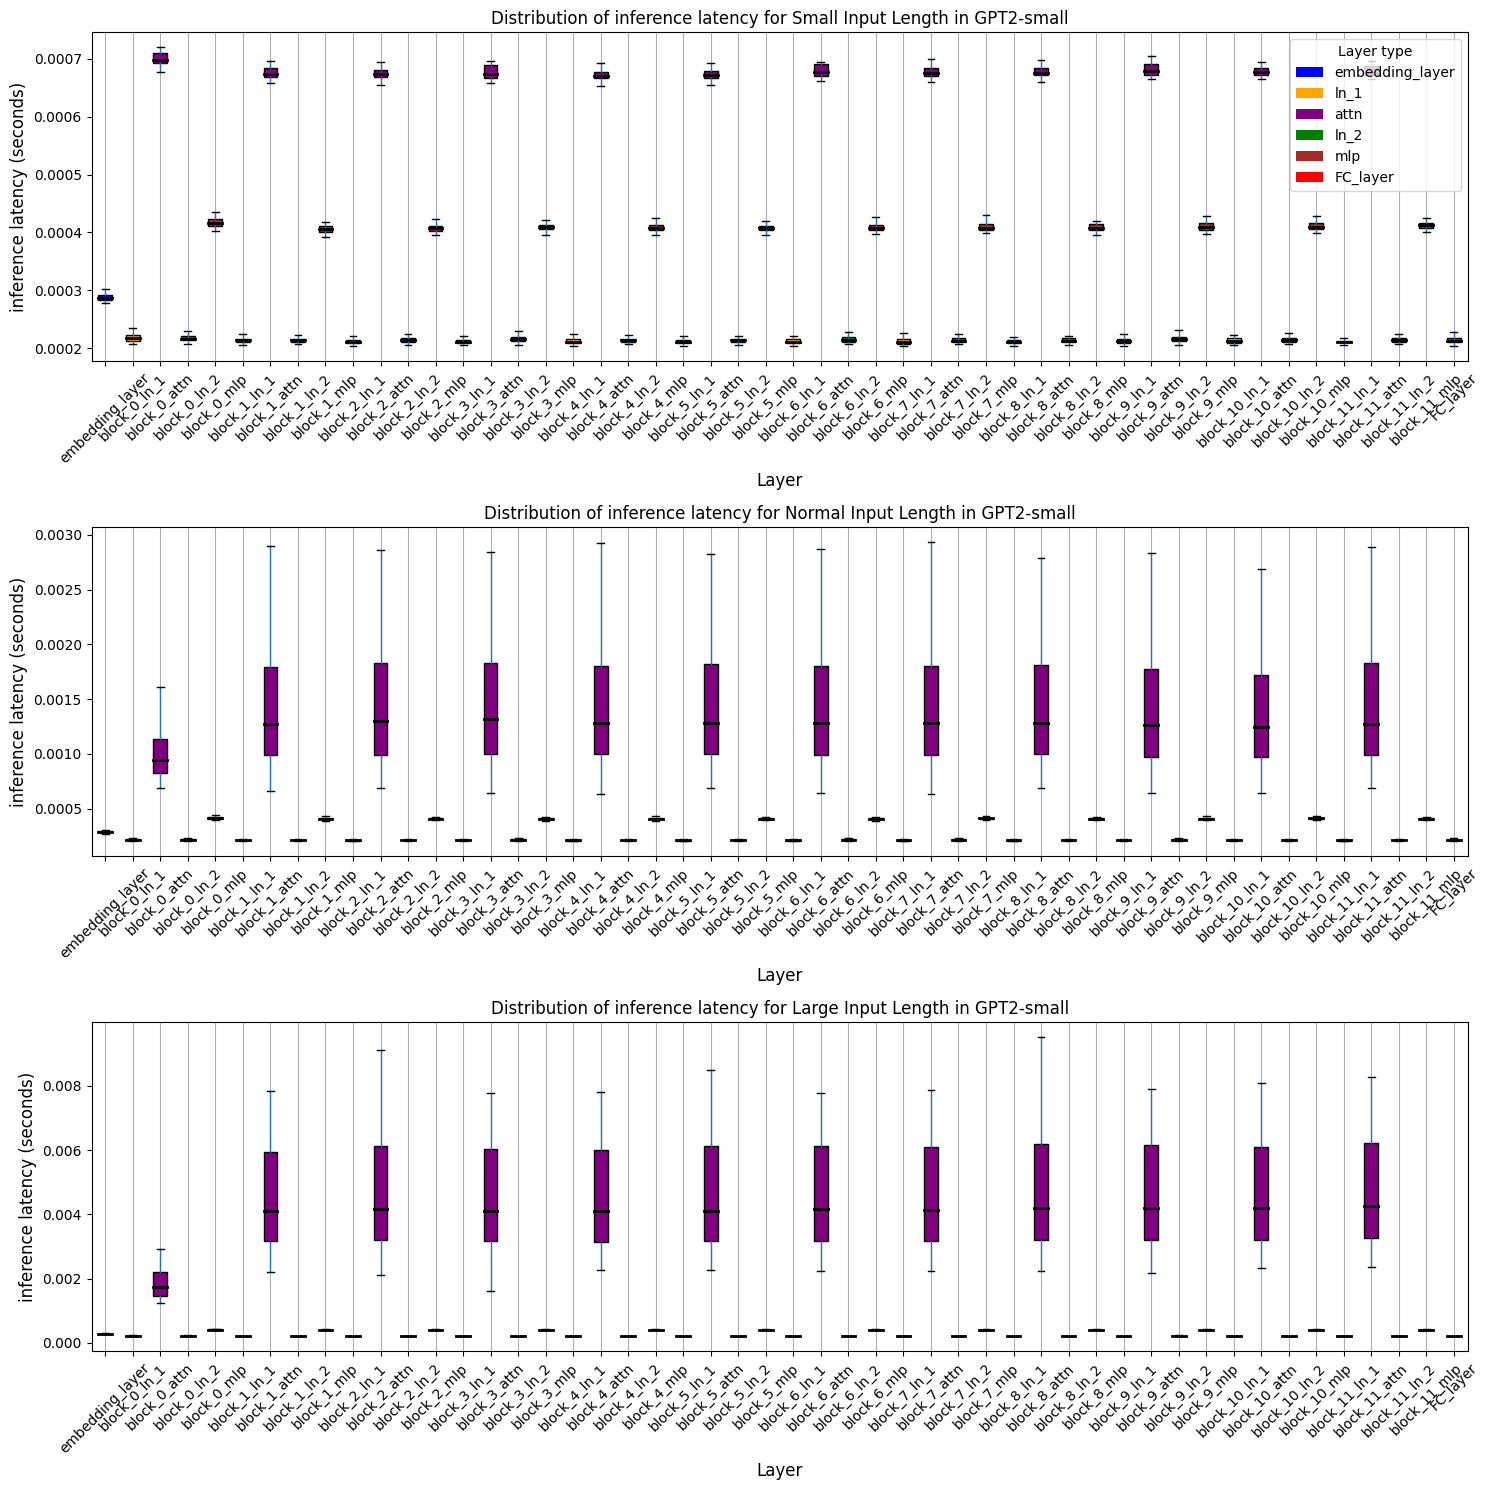

In [56]:
plot_layer_profiling_split(
    gpt2_latency_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_latency_dist_split.pdf',
    metric='inference latency',
    unit='seconds',
)

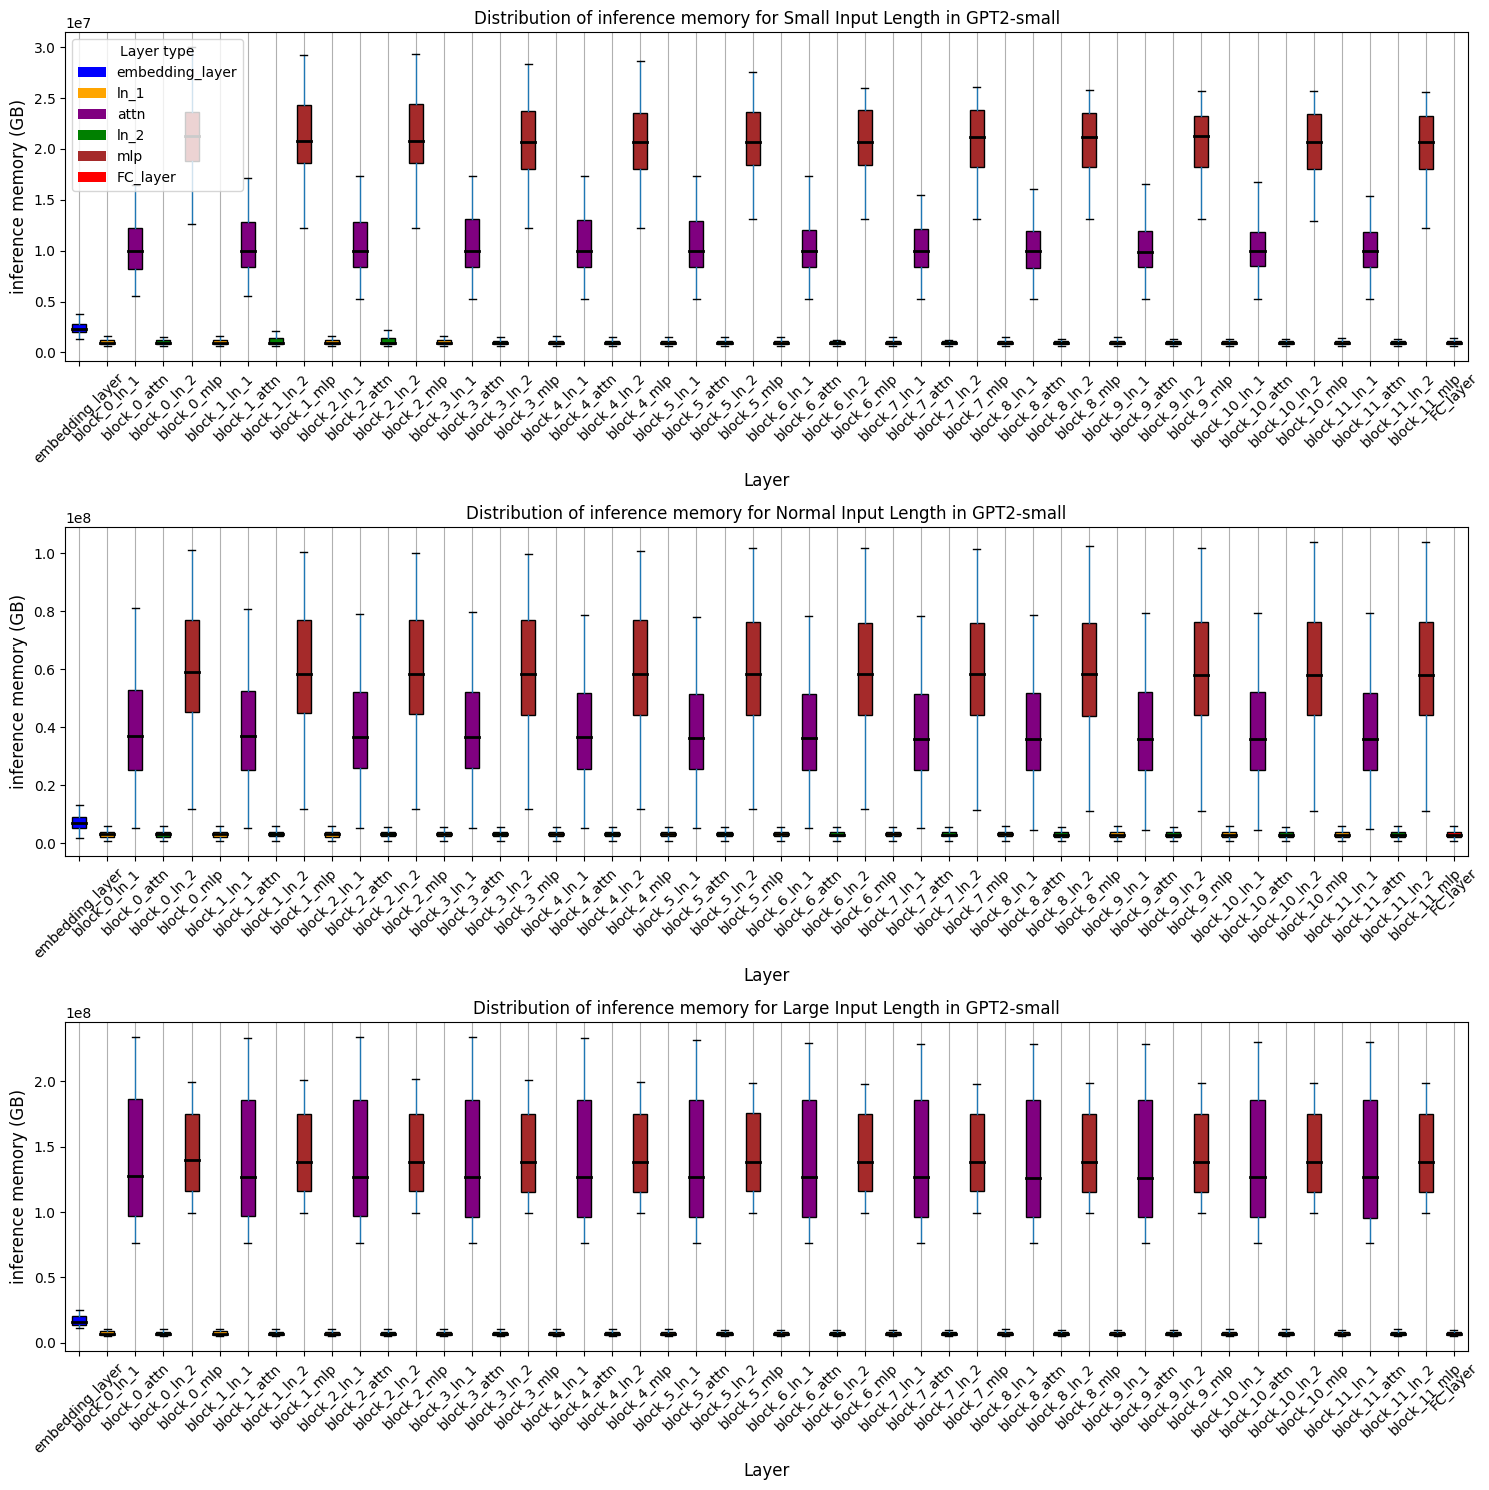

In [57]:
plot_layer_profiling_split(
    gpt2_memory_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_memory_dist_split.pdf',
    metric='inference memory',
    unit='GB',
)

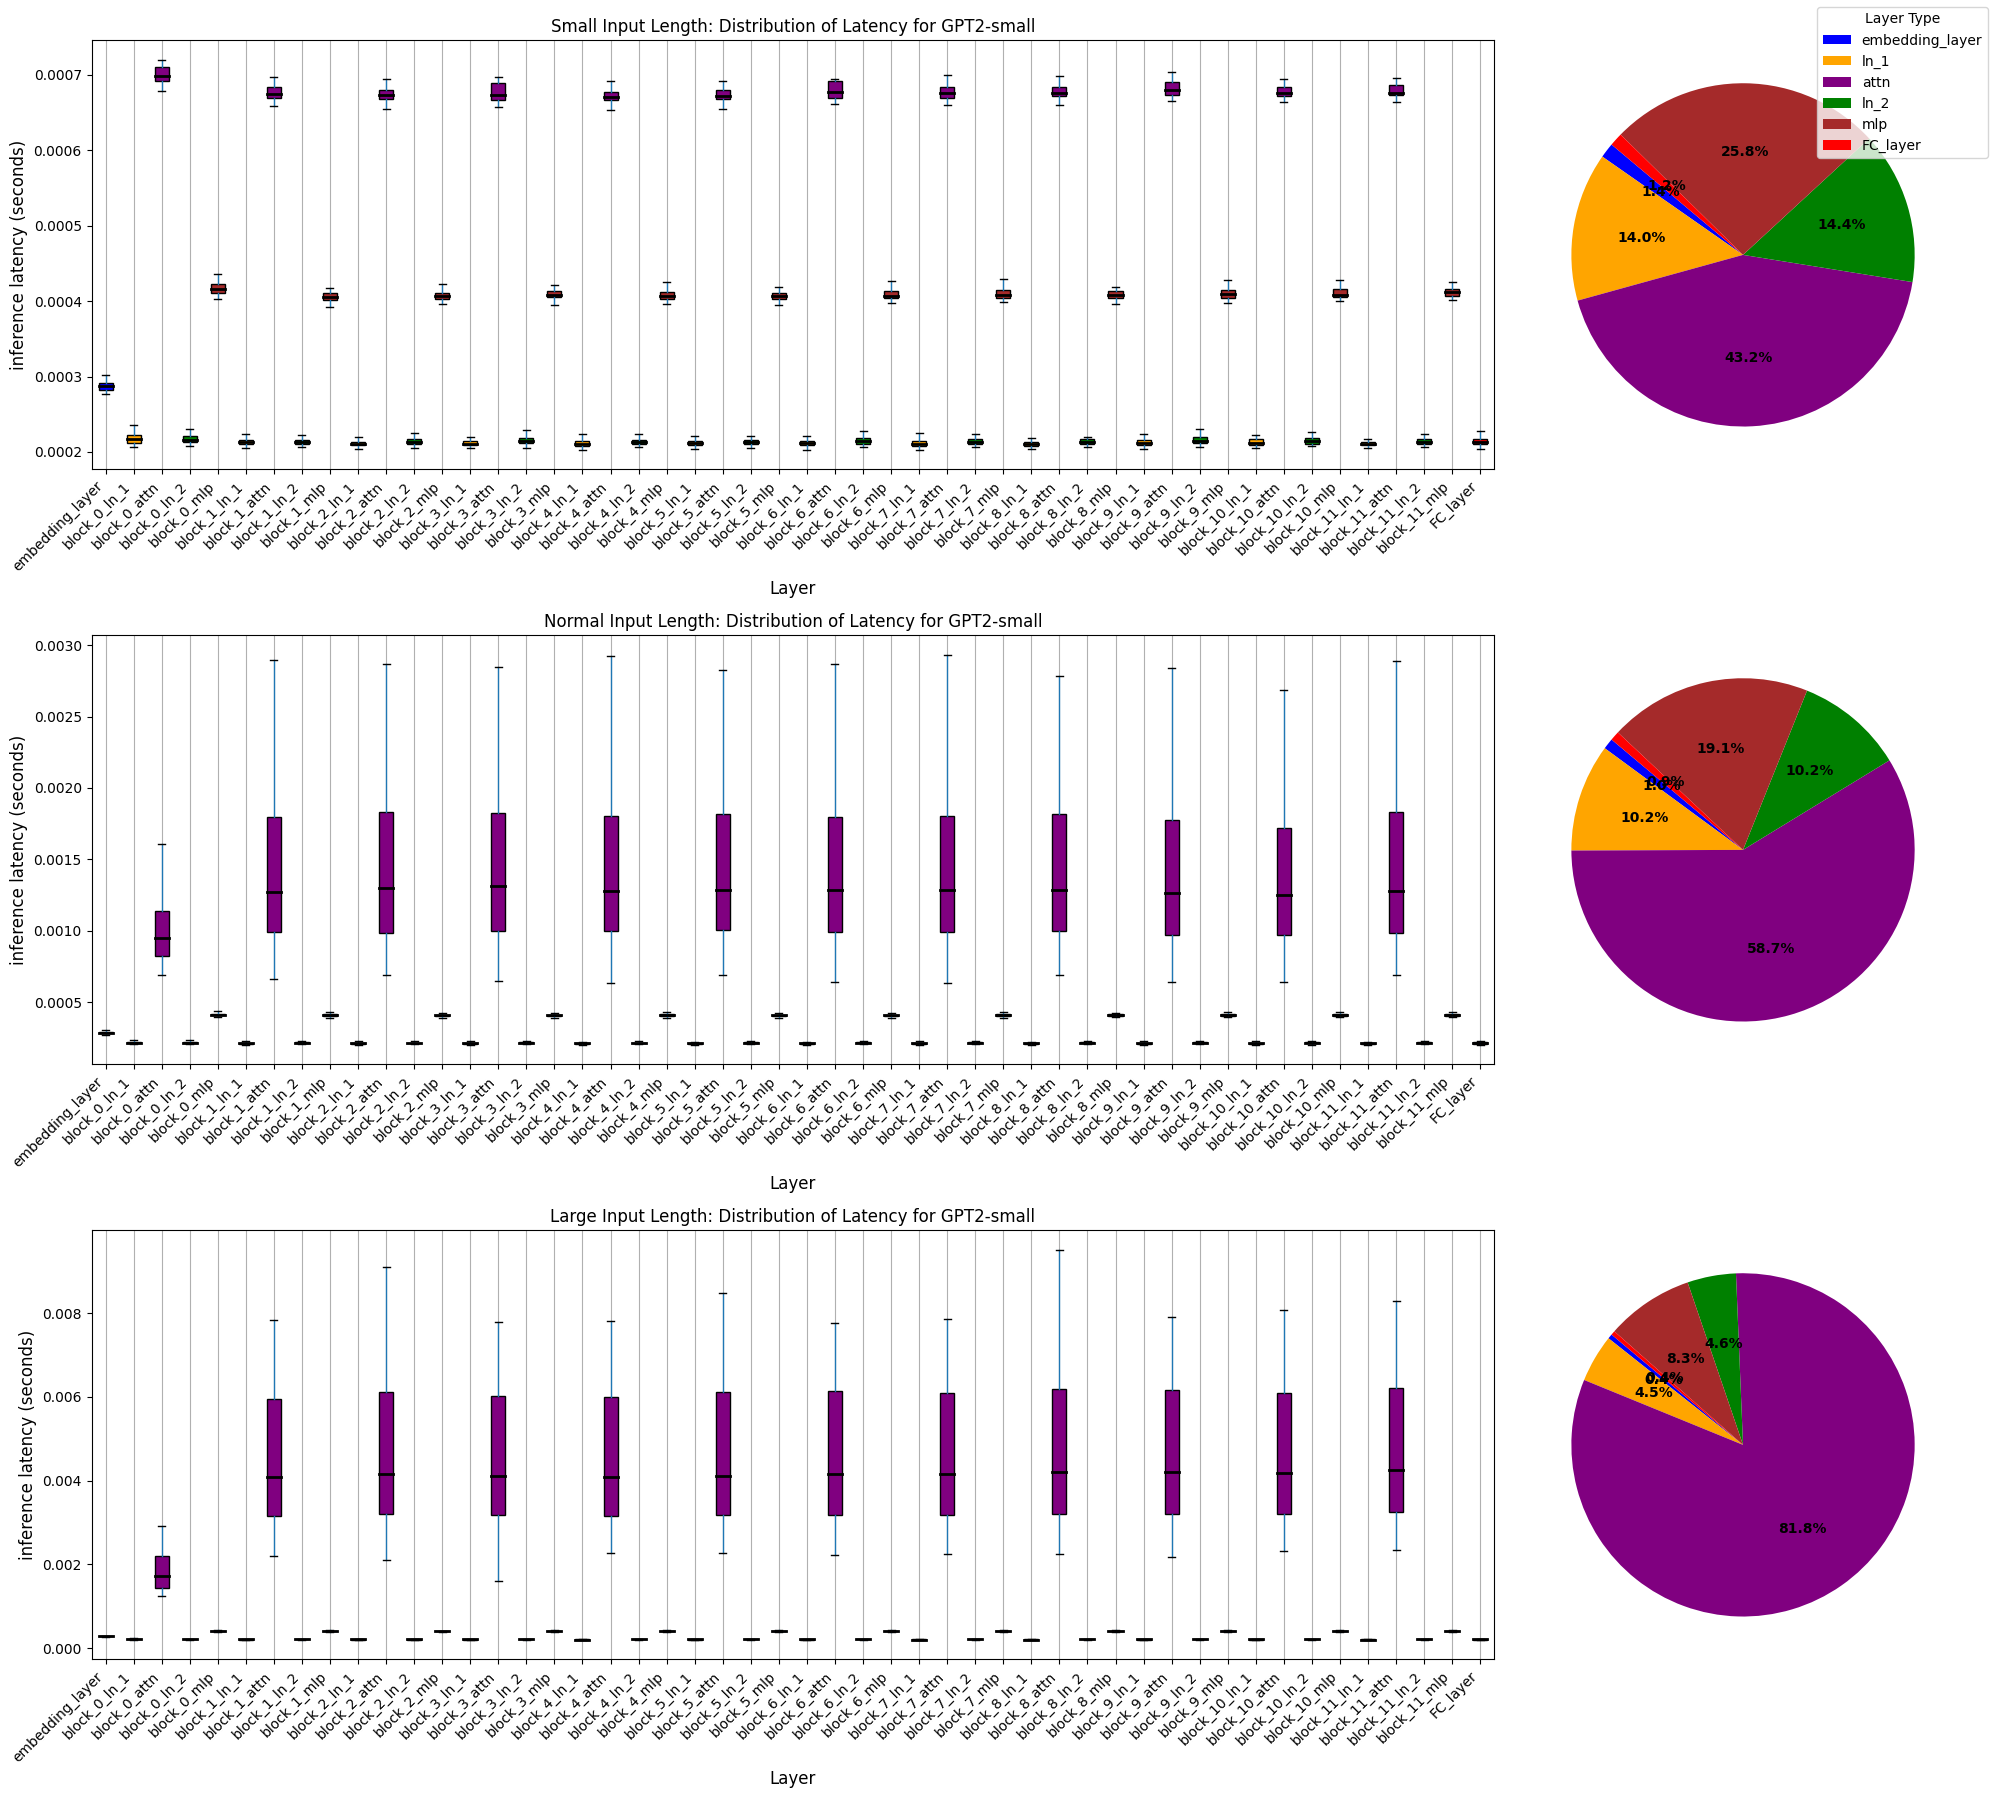

In [87]:
plot_combined_charts(
    gpt2_latency_res,
    'GPT2-small',
    save_file='figures/gpt2_layer_latency_split_combined.pdf',
    metric='inference latency',
    unit='seconds',
)

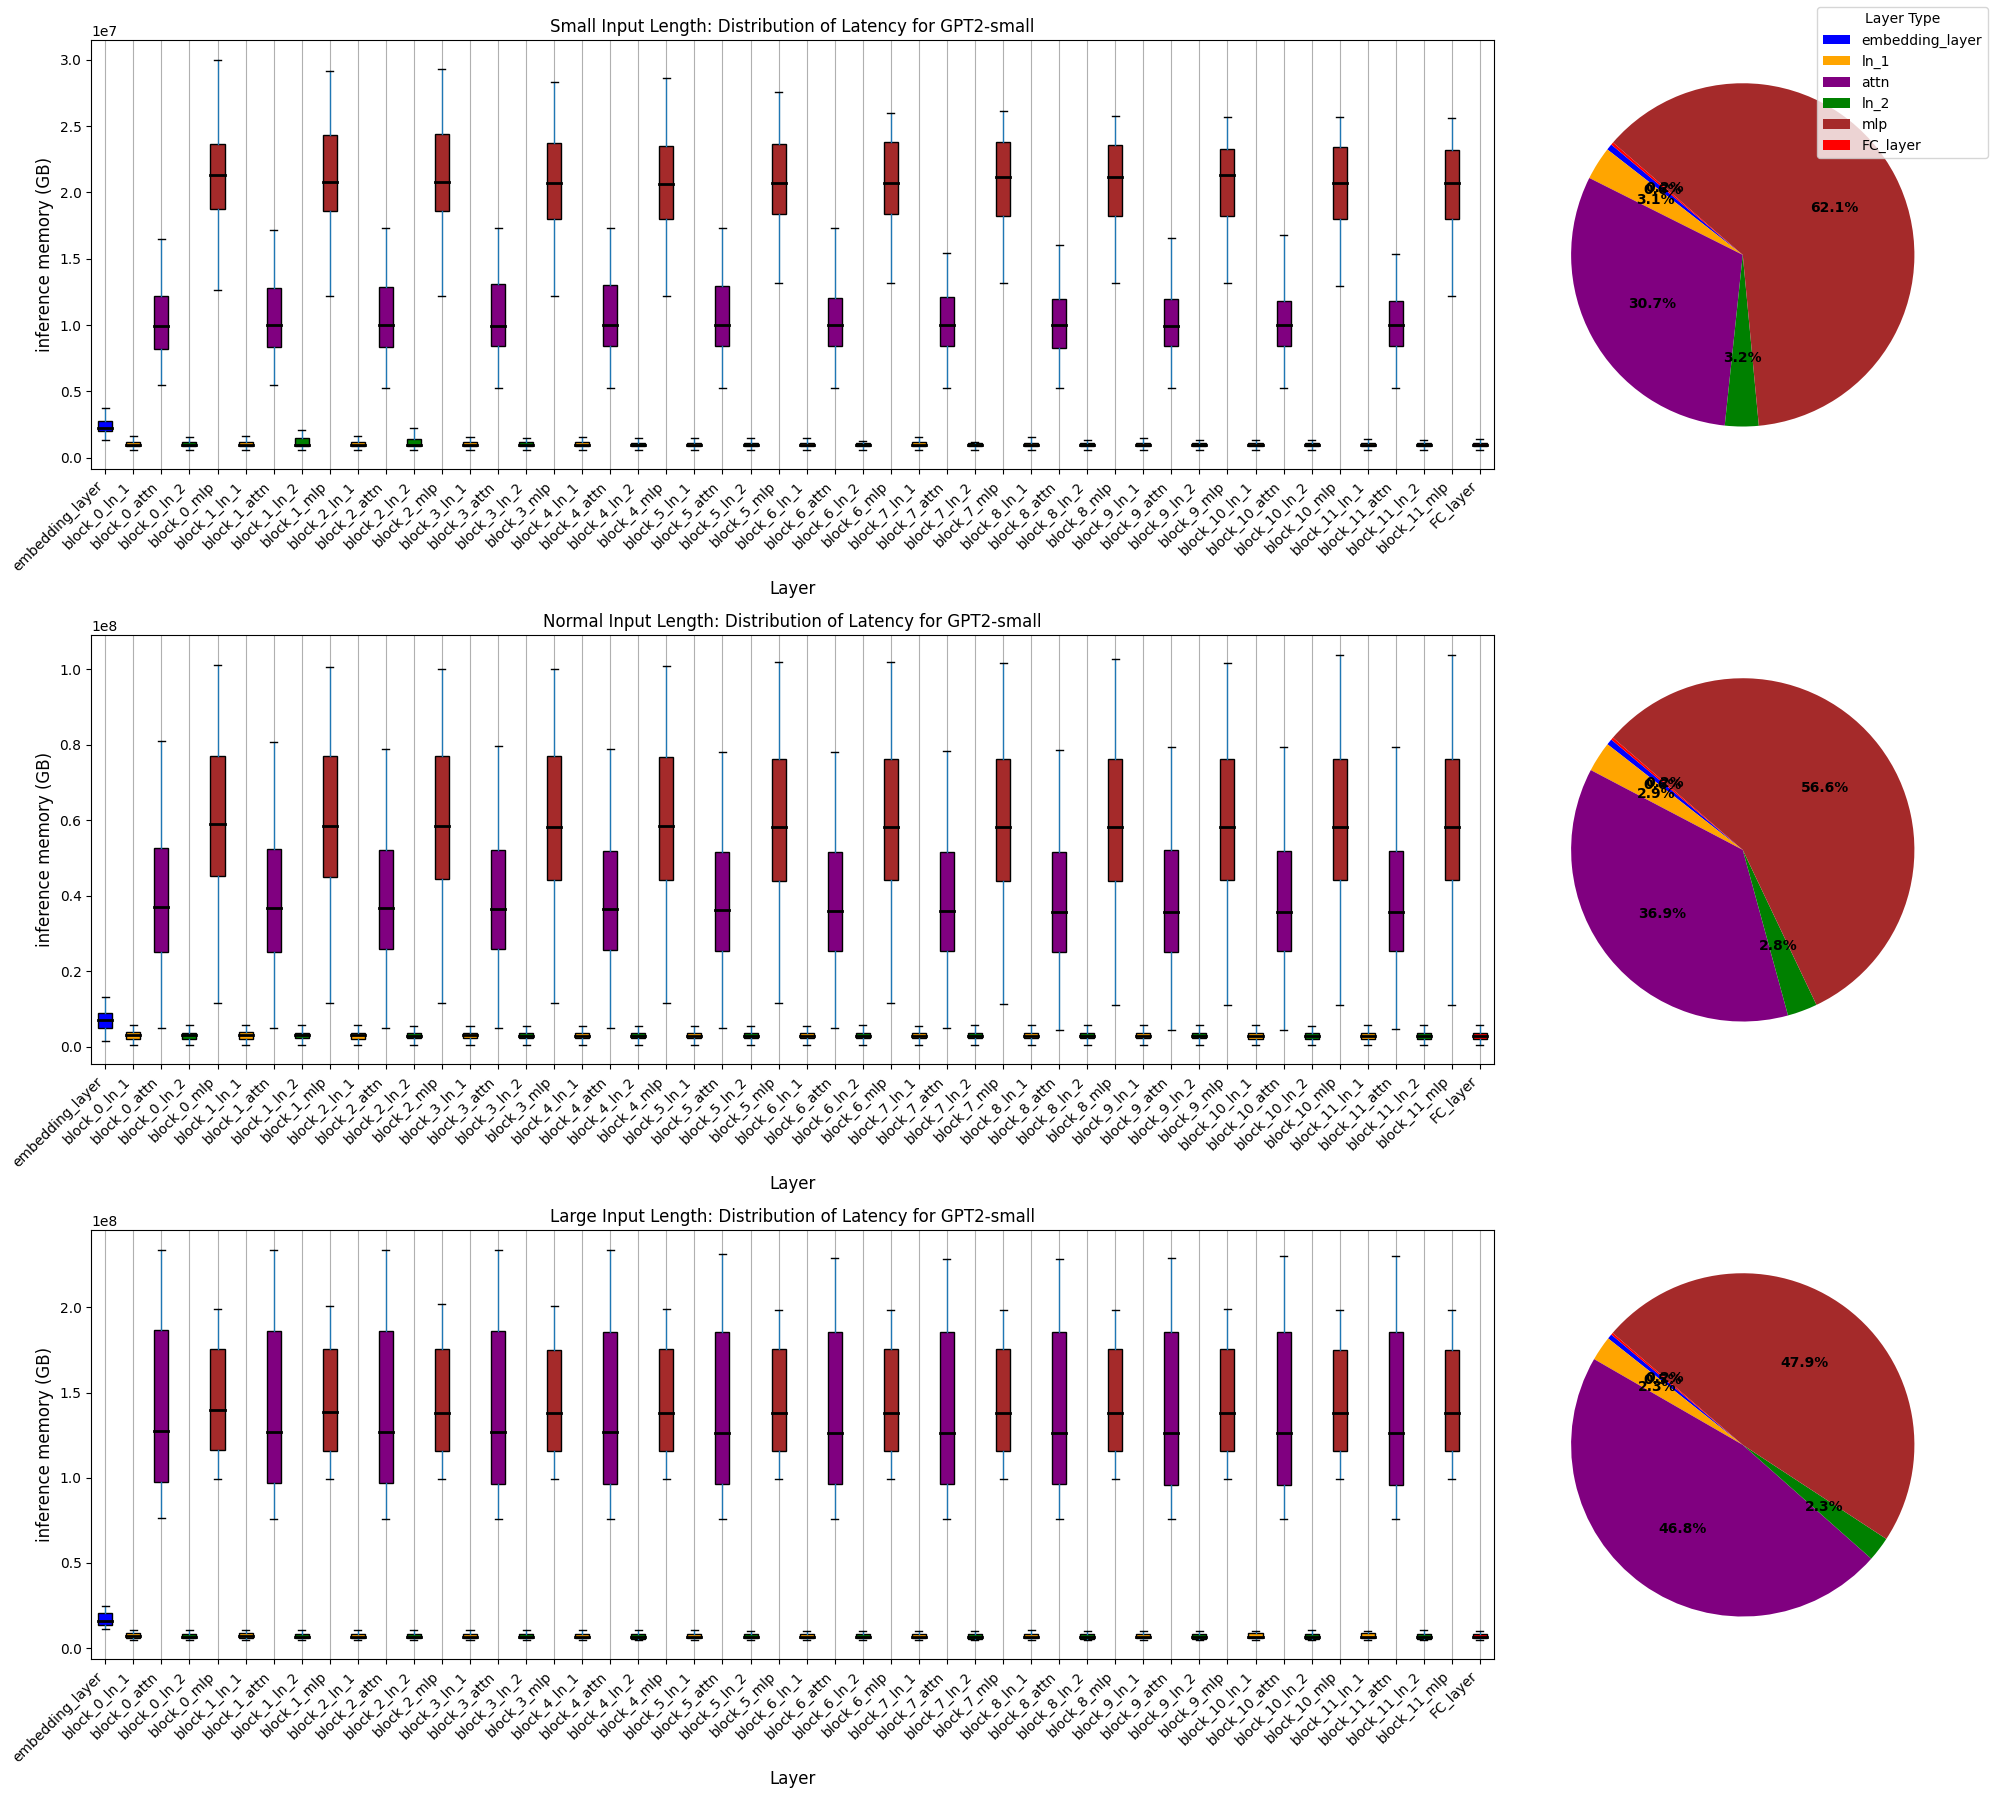

In [88]:
plot_combined_charts(
    gpt2_memory_res,
    'GPT2-small',
    save_file='figures/gpt2_layer_memory_split_combined.pdf',
    metric='inference memory',
    unit='GB',
)

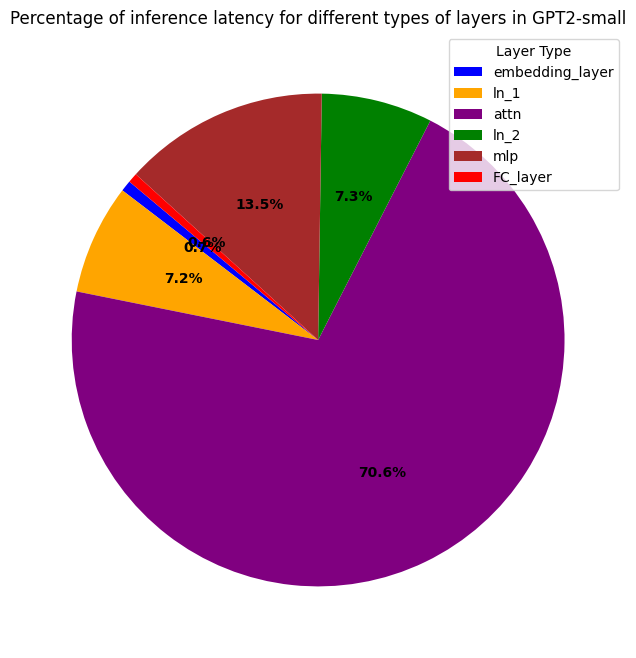

In [68]:
plot_pie_chart(
    gpt2_latency_res,
    'GPT2-small',
    save_file='figures/gpt2_pie_latency.pdf',
    metric='inference latency',
)

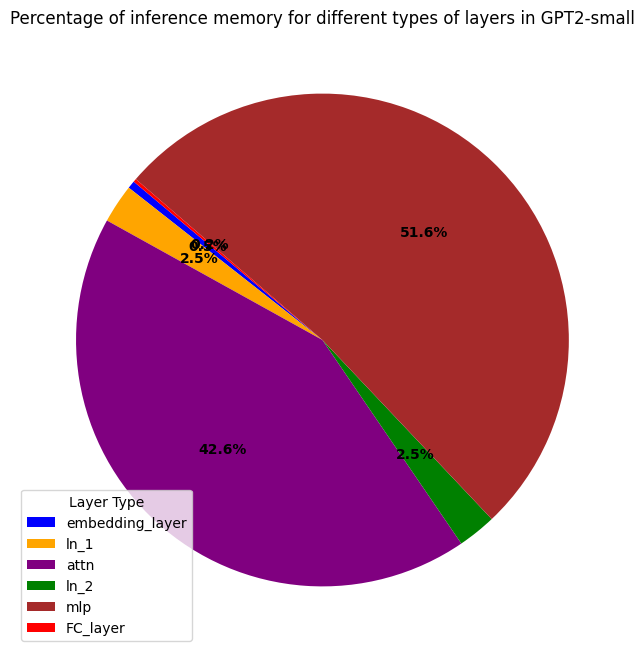

In [69]:
plot_pie_chart(
    gpt2_memory_res,
    'GPT2-small',
    save_file='figures/gpt2_pie_memory.pdf',
    metric='inference memory',
)

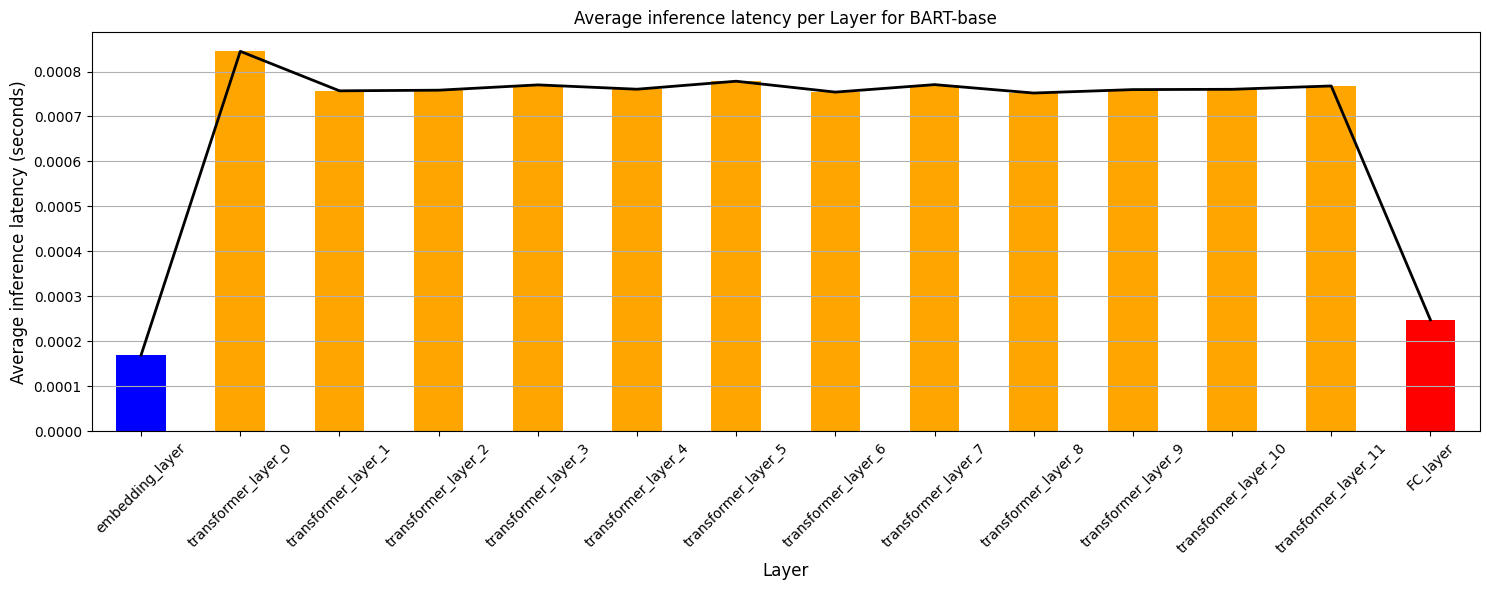

In [50]:
plot_layer_profiling(
    bart_latency_res, 
    'BART-base', 
    save_file='figures/bart_layer_latency.pdf',
    metric='inference latency',
    unit='seconds',
)

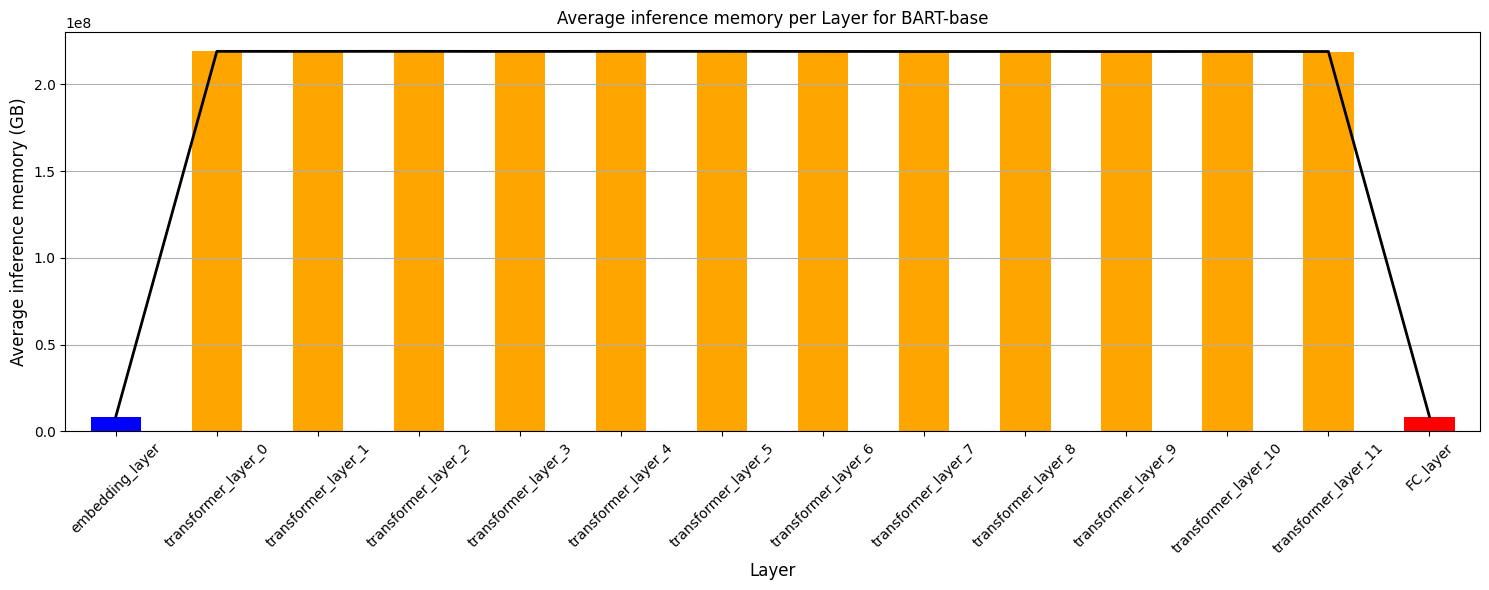

In [51]:
plot_layer_profiling(
    bart_memory_res, 
    'BART-base', 
    save_file='figures/bart_layer_memory.pdf',
    metric='inference memory',
    unit='GB',
)

## Layer profiler

In [73]:
latency_bert = pd.DataFrame(json.load(open('profile_res/latency_forward_bert-base-uncased.json')))
memory_bert = pd.DataFrame(json.load(open('profile_res/memory_forward_bert-base-uncased.json')))
input_len_bert = pd.DataFrame(json.load(open('profile_res/input_length_bert-base-uncased.json')))

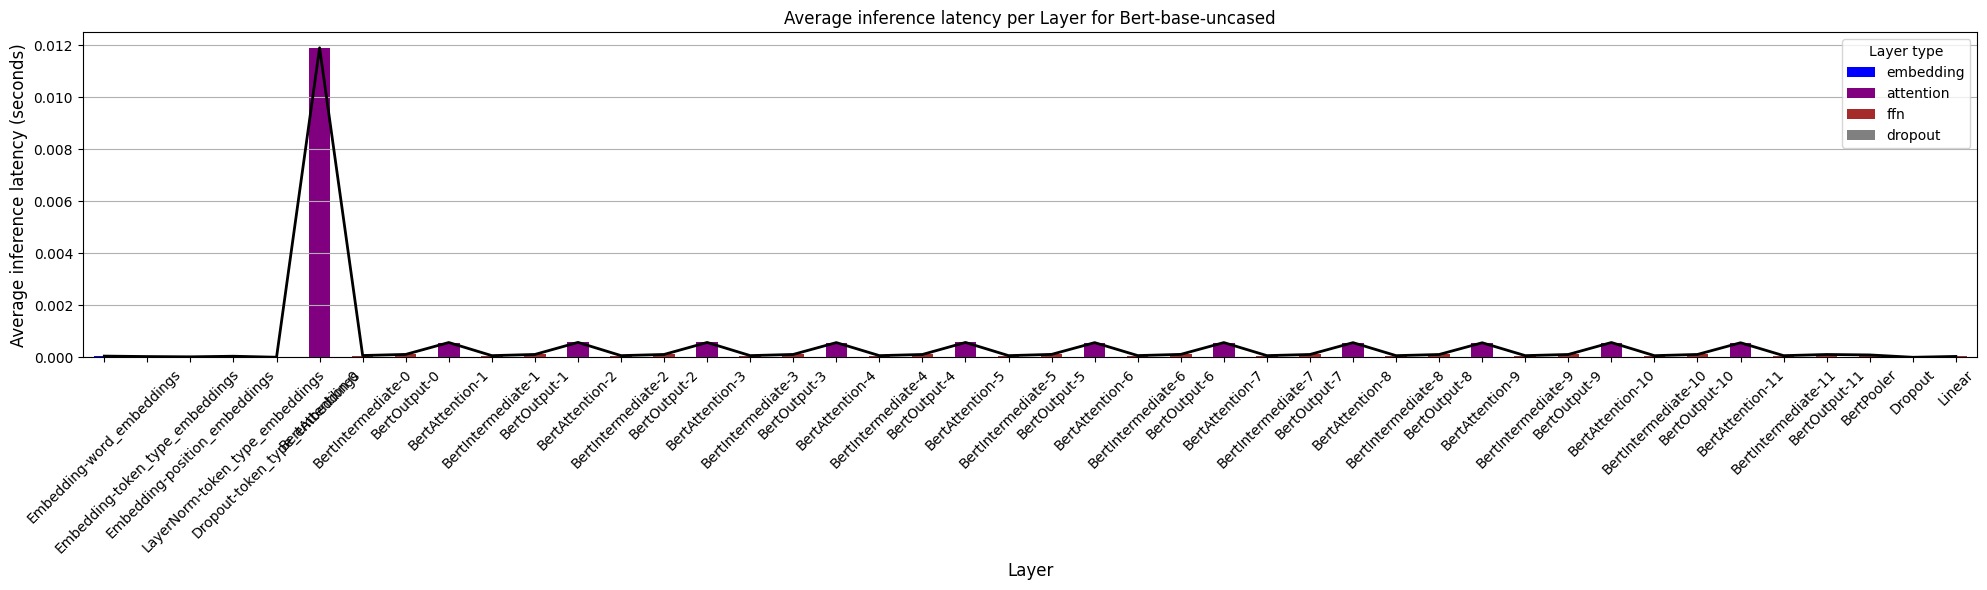

In [74]:
plot_layer_profiling(
    latency_bert, 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_latency_forward_average.pdf',
    metric='inference latency',
    unit='seconds',
)

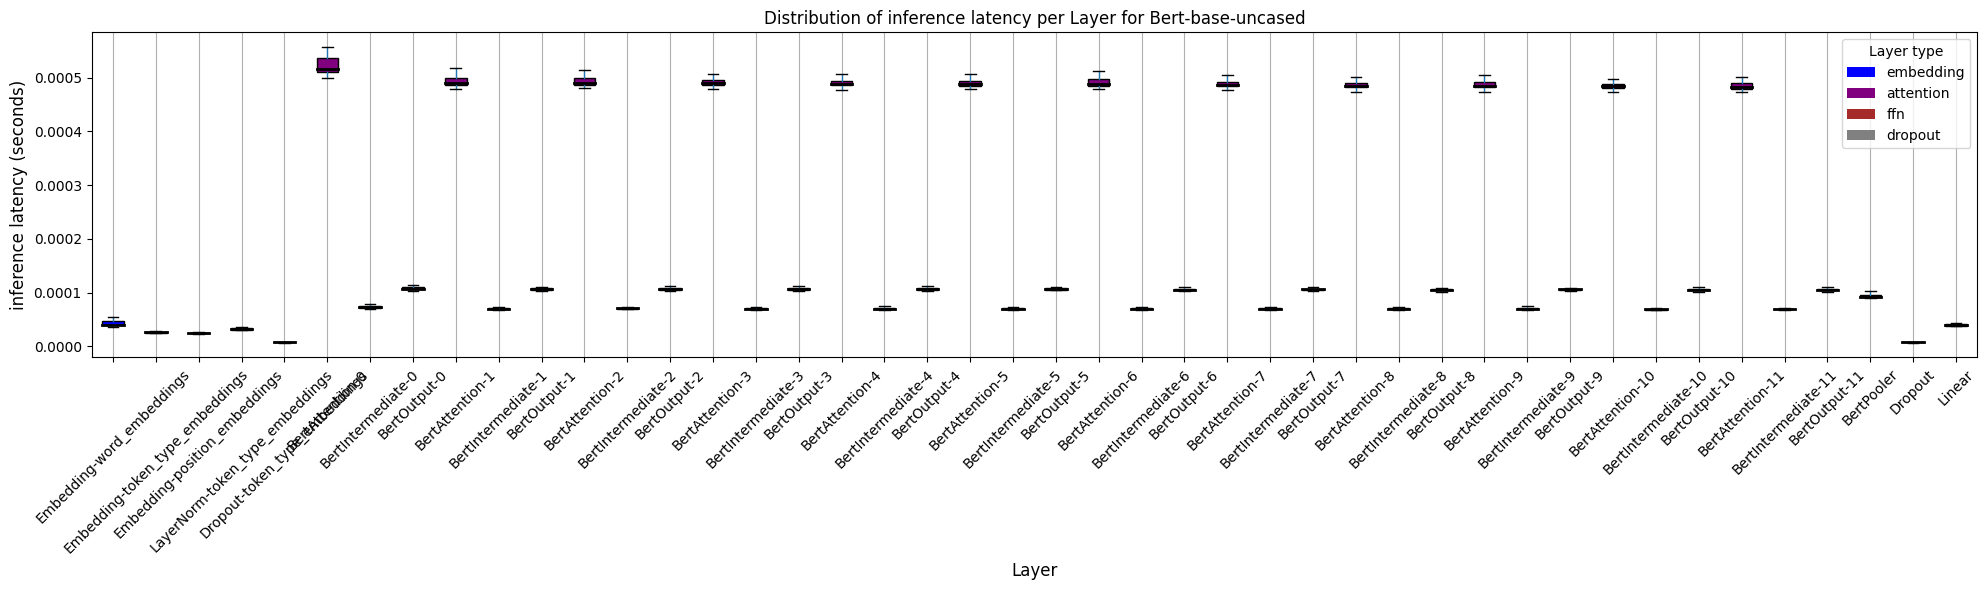

In [75]:
plot_layer_profiling_dist(
    latency_bert, 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_latency_forward_dist.pdf',
    metric='inference latency',
    unit='seconds',
)

### Training

In [78]:
output_dir = 'results/text-classification/bert-base-uncased'
forward_input_len_bert = pd.DataFrame(json.load(open(f'{output_dir}/train_input_length_bert-base-uncased.json')))
forward_latency_bert = pd.DataFrame(json.load(open(f'{output_dir}/train_latency_forward_bert-base-uncased.json')))
forward_memory_bert = pd.DataFrame(json.load(open(f'{output_dir}/train_memory_forward_bert-base-uncased.json')))
backward_latency_bert = pd.DataFrame(json.load(open(f'{output_dir}/train_latency_backward_bert-base-uncased.json')))
backward_memory_bert = pd.DataFrame(json.load(open(f'{output_dir}/train_memory_backward_bert-base-uncased.json')))

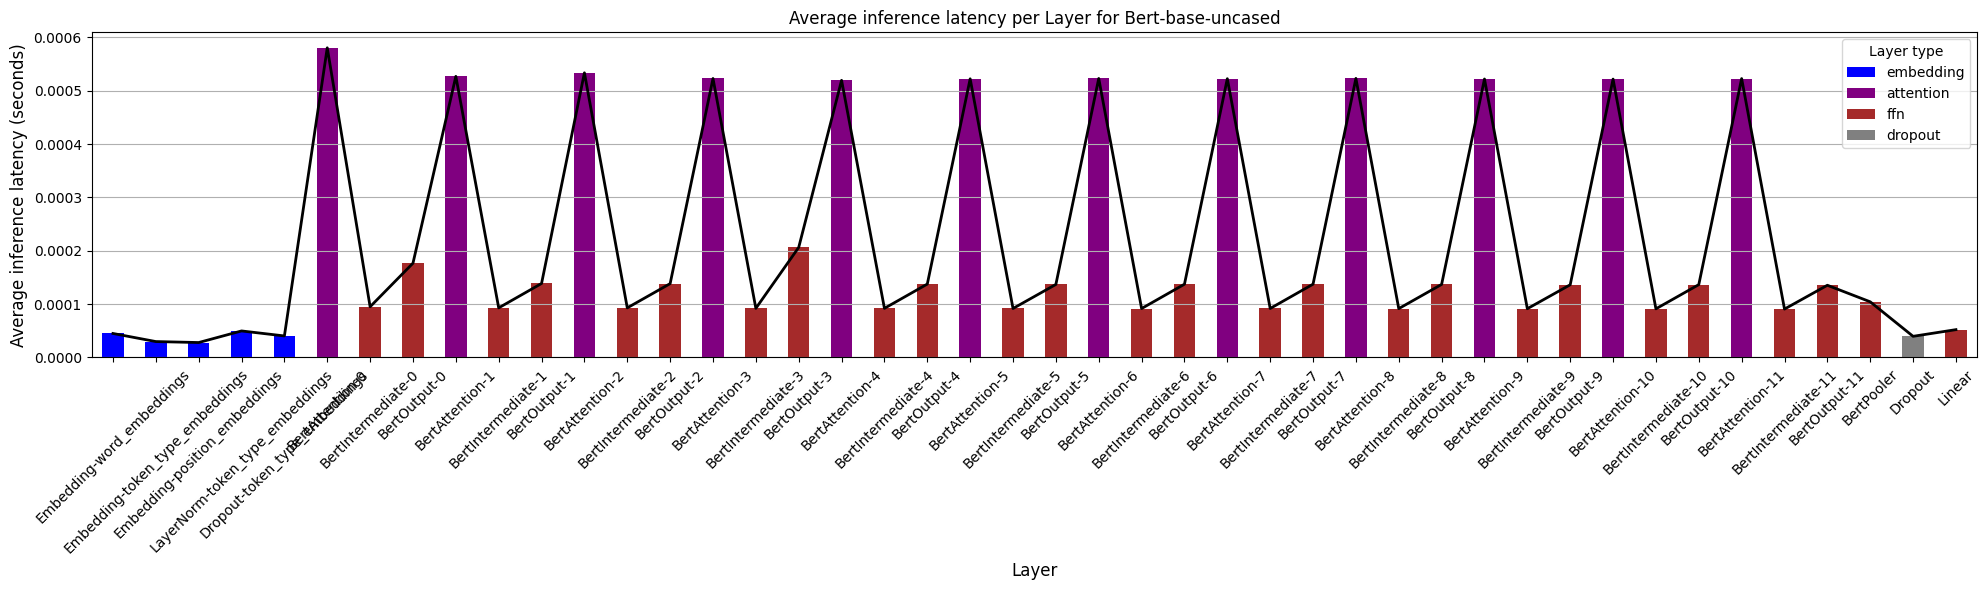

In [79]:
plot_layer_profiling(
    forward_latency_bert, 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_latency_forward_average.pdf',
    metric='inference latency',
    unit='seconds',
)

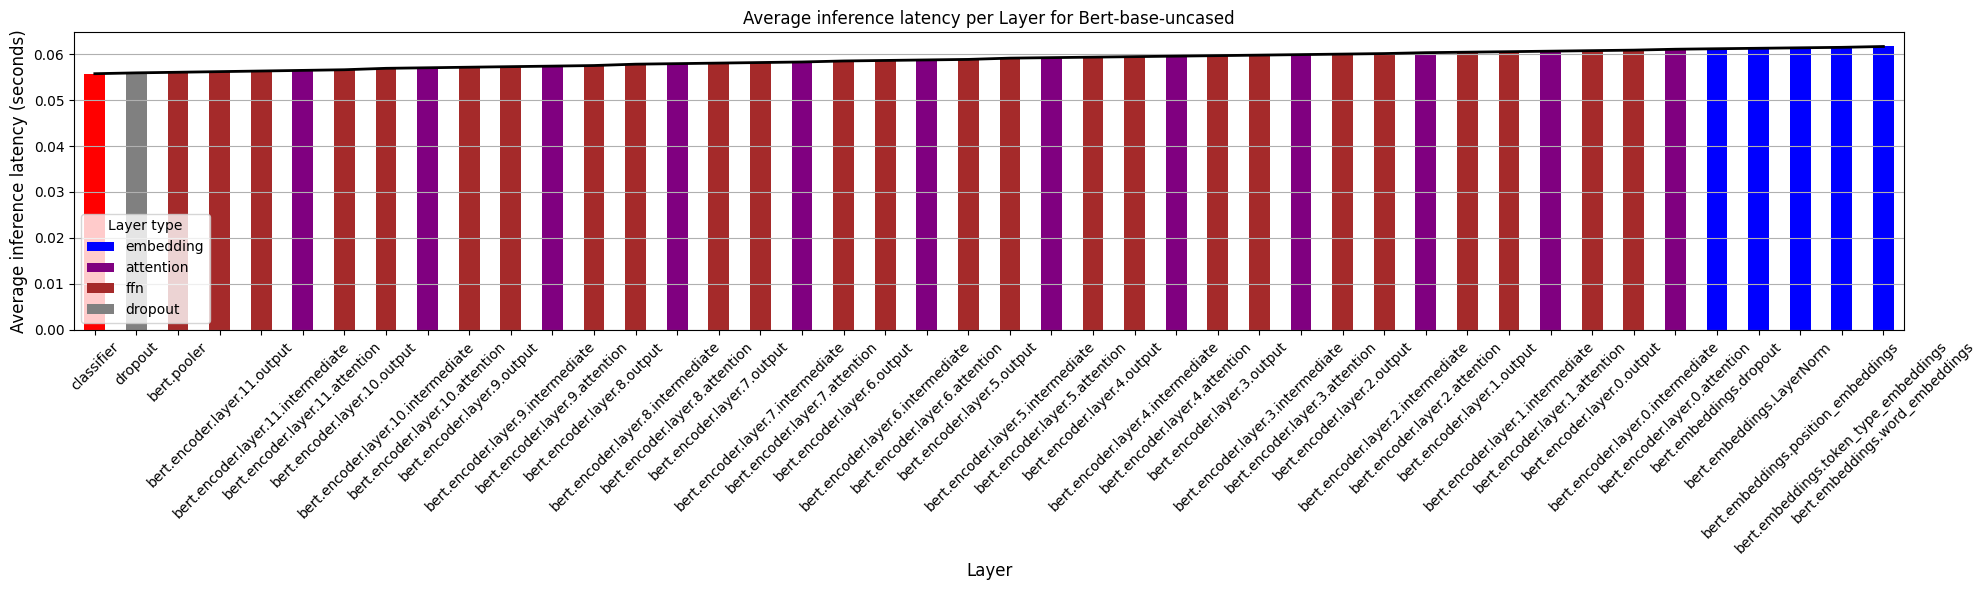

In [80]:
plot_layer_profiling(
    backward_latency_bert, 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_latency_backward_average.pdf',
    metric='inference latency',
    unit='seconds',
)

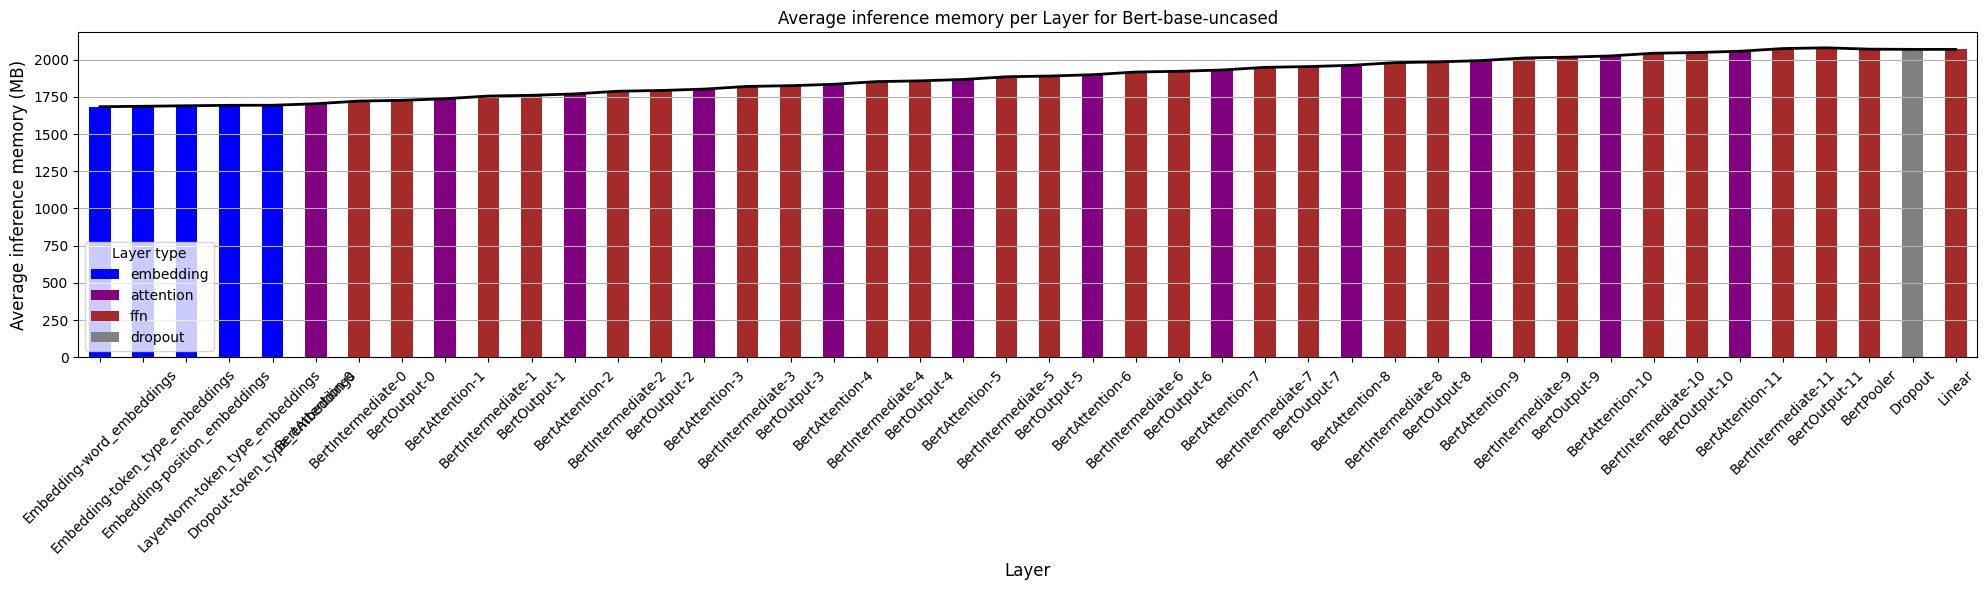

In [83]:
plot_layer_profiling(
    forward_memory_bert/(1024 ** 2), 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_memory_forward_average.pdf',
    metric='inference memory',
    unit='MB',
)

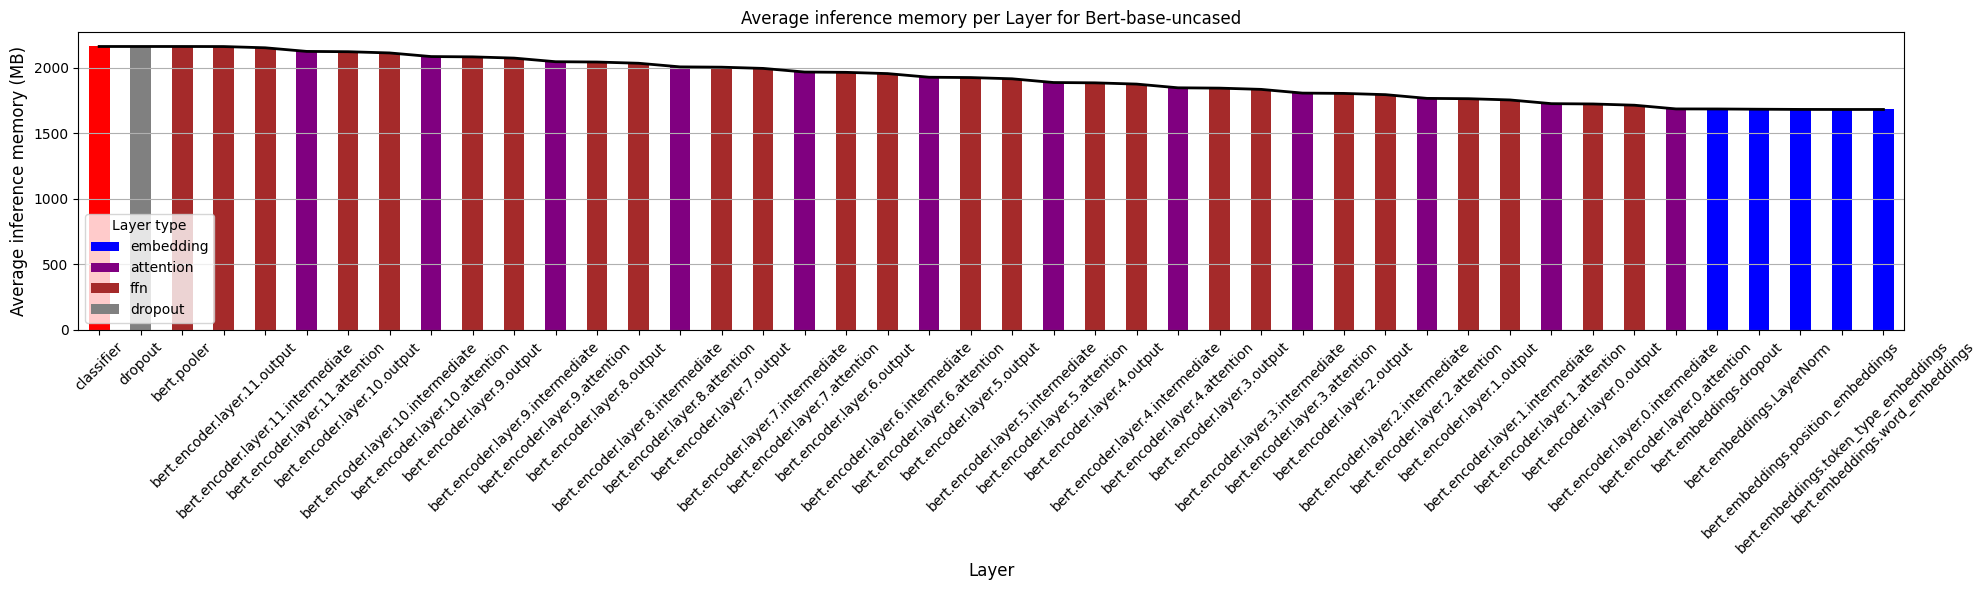

In [84]:
plot_layer_profiling(
    backward_memory_bert/(1024 ** 2), 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_memory_backward_average.pdf',
    metric='inference memory',
    unit='MB',
)

### Testing

In [86]:
output_dir = 'results/text-classification/bert-base-uncased'
forward_input_len_bert = pd.DataFrame(json.load(open(f'{output_dir}/eval_input_length_bert-base-uncased.json')))
forward_latency_bert = pd.DataFrame(json.load(open(f'{output_dir}/eval_latency_forward_bert-base-uncased.json')))
forward_memory_bert = pd.DataFrame(json.load(open(f'{output_dir}/eval_memory_forward_bert-base-uncased.json')))

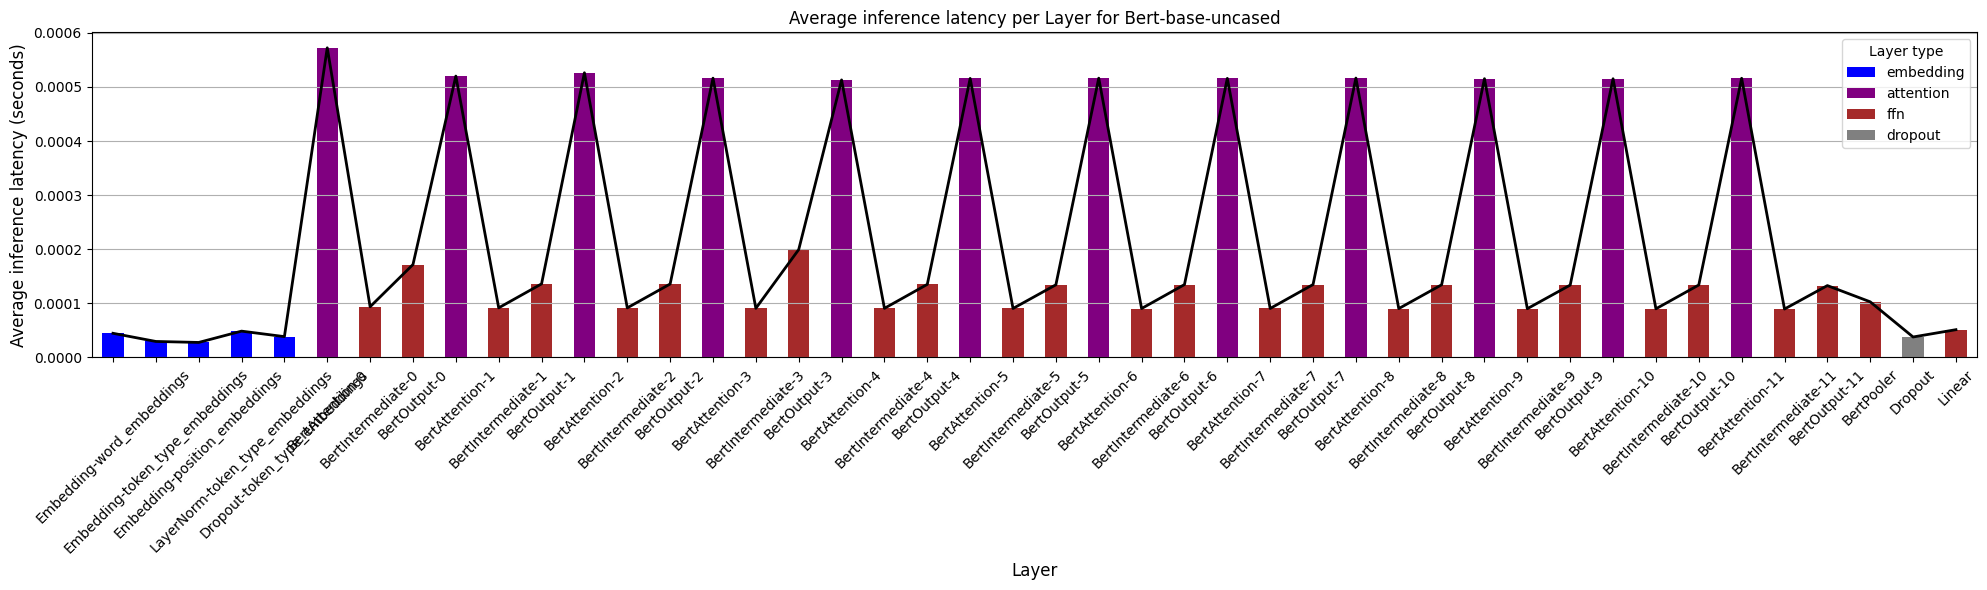

In [87]:
plot_layer_profiling(
    forward_latency_bert, 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_latency_forward_average(eval).pdf',
    metric='inference latency',
    unit='seconds',
)

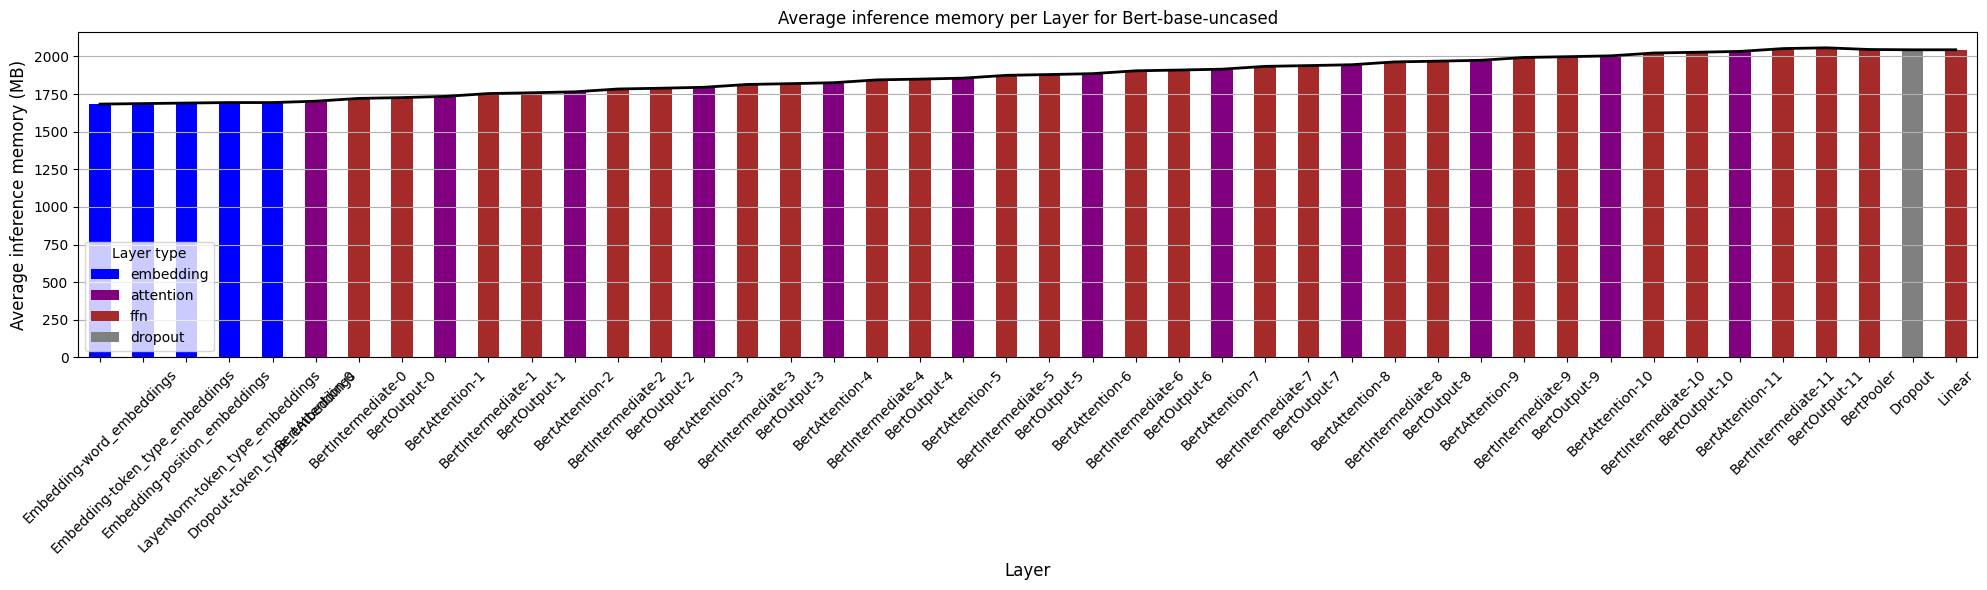

In [88]:
plot_layer_profiling(
    forward_memory_bert/(1024 ** 2), 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_memory_forward_average(eval).pdf',
    metric='inference memory',
    unit='MB',
)